In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import OneClassSVM

from sklearn.manifold import MDS, TSNE
from sklearn.svm import SVR

import pandas as pd
from pyprojroot import here
import itertools

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import spearmanr
from scipy.cluster import hierarchy


# These data were aggregated from a number of sources including the American Community Survey (census.gov), clinicaltrials.gov, and cancer.gov.

## OLS Regression Challenge 
### cancer_reg.csv

<pre><code>

TARGET_deathRate: Dependent variable. Mean per capita (100,000) cancer mortalities(a)

avgAnnCount: Mean number of reported cases of cancer diagnosed annually(a)

avgDeathsPerYear: Mean number of reported mortalities due to cancer(a)

incidenceRate: Mean per capita (100,000) cancer diagoses(a)

medianIncome: Median income per county (b)

popEst2015: Population of county (b)

povertyPercent: Percent of populace in poverty (b)

studyPerCap: Per capita number of cancer-related clinical trials per county (a)

binnedInc: Median income per capita binned by decile (b)

MedianAge: Median age of county residents (b)

MedianAgeMale: Median age of male county residents (b)

MedianAgeFemale: Median age of female county residents (b)

Geography: County name (b)

AvgHouseholdSize: Mean household size of county (b)

PercentMarried: Percent of county residents who are married (b)

PctNoHS18_24: Percent of county residents ages 18-24 highest education attained: less than high school (b)

PctHS18_24: Percent of county residents ages 18-24 highest education attained: high school diploma (b)

PctSomeCol18_24: Percent of county residents ages 18-24 highest education attained: some college (b)

PctBachDeg18_24: Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)

PctHS25_Over: Percent of county residents ages 25 and over highest education attained: high school diploma (b)

PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)

PctEmployed16_Over: Percent of county residents ages 16 and over employed (b)

PctUnemployed16_Over: Percent of county residents ages 16 and over unemployed (b)

PctPrivateCoverage: Percent of county residents with private health coverage (b)

PctPrivateCoverageAlone: Percent of county residents with private health coverage alone (no public assistance) (b)

PctEmpPrivCoverage: Percent of county residents with employee-provided private health coverage (b)

PctPublicCoverage: Percent of county residents with government-provided health coverage (b)

PctPubliceCoverageAlone: Percent of county residents with government-provided health coverage alone (b)

PctWhite: Percent of county residents who identify as White (b)

PctBlack: Percent of county residents who identify as Black (b)

PctAsian: Percent of county residents who identify as Asian (b)

PctOtherRace: Percent of county residents who identify in a category which is not White, Black, or Asian (b)

PctMarriedHouseholds: Percent of married households (b)

BirthRate: Number of live births relative to number of women in county (b)

</code></pre>

## Objetivo predecir la cantidad de muertes por cancer en los condados de USA

In [2]:
path_data = here() / 'Martu' / 'Maestria' / 'data_mining' / 'practico3' / 'Datos'

In [3]:
df = pd.read_csv(path_data / 'cancer_reg.csv', sep=',', comment='#', header=0)
print(df.shape)
df.head(5)

(3047, 34)


,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


## Preprocesamiento 
quitar
* medIncome - binnedInc
* Geography - County/City, State

In [4]:
y_=df['TARGET_deathRate'].to_numpy()

df.drop(['TARGET_deathRate'], axis=1, inplace=True)
df.drop(['binnedInc'], axis=1, inplace=True)
df.drop(['Geography'], axis=1, inplace=True)


### Hay valores NA ?

In [5]:
X_ = df.to_numpy()
print('NaNs: ', np.sum(np.isnan(X_)))

NaNs:  3046


### Divido test y train - Normalizo los datos
### [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) imputar valores faltantes

In [6]:
st = StandardScaler(with_mean=True, with_std=True)
st_y = StandardScaler(with_mean=True, with_std=True)

t_for_test_only = KFold(n_splits=5, random_state=0, shuffle=True)
train, test = list(t_for_test_only.split(X_, y_))[0]


X = X_[train]
y = y_[train]
X_te = X_[test]
y_te = y_[test]

imputer = KNNImputer(n_neighbors=1)
X = imputer.fit_transform(X)
X_te = imputer.transform(X_te)
print('NaNs: ', np.sum(np.isnan(X)))
print('NaNs: ', np.sum(np.isnan(X_te)))

X = st.fit_transform(X)
y = st_y.fit_transform(y.reshape(-1, 1)).ravel()
X_te = st.transform(X_te)
y_te = st_y.transform(y_te.reshape(-1, 1)).ravel()

NaNs:  0
NaNs:  0


### Visualizacion - PCA - Kernel PCA y t-SNE

In [7]:
pc = PCA(n_components=20)
x_pc = pc.fit_transform(X)
print(pc.explained_variance_ratio_.sum())

kpc = KernelPCA(n_components=2, kernel='rbf', degree=3, gamma=0.0005, fit_inverse_transform=True)
x_kpc = kpc.fit_transform(X)

kpc2 = KernelPCA(n_components=2, kernel='poly', degree=2, gamma=0.0005, fit_inverse_transform=True)
x_kpc2 = kpc2.fit_transform(X)

0.9715340648498296


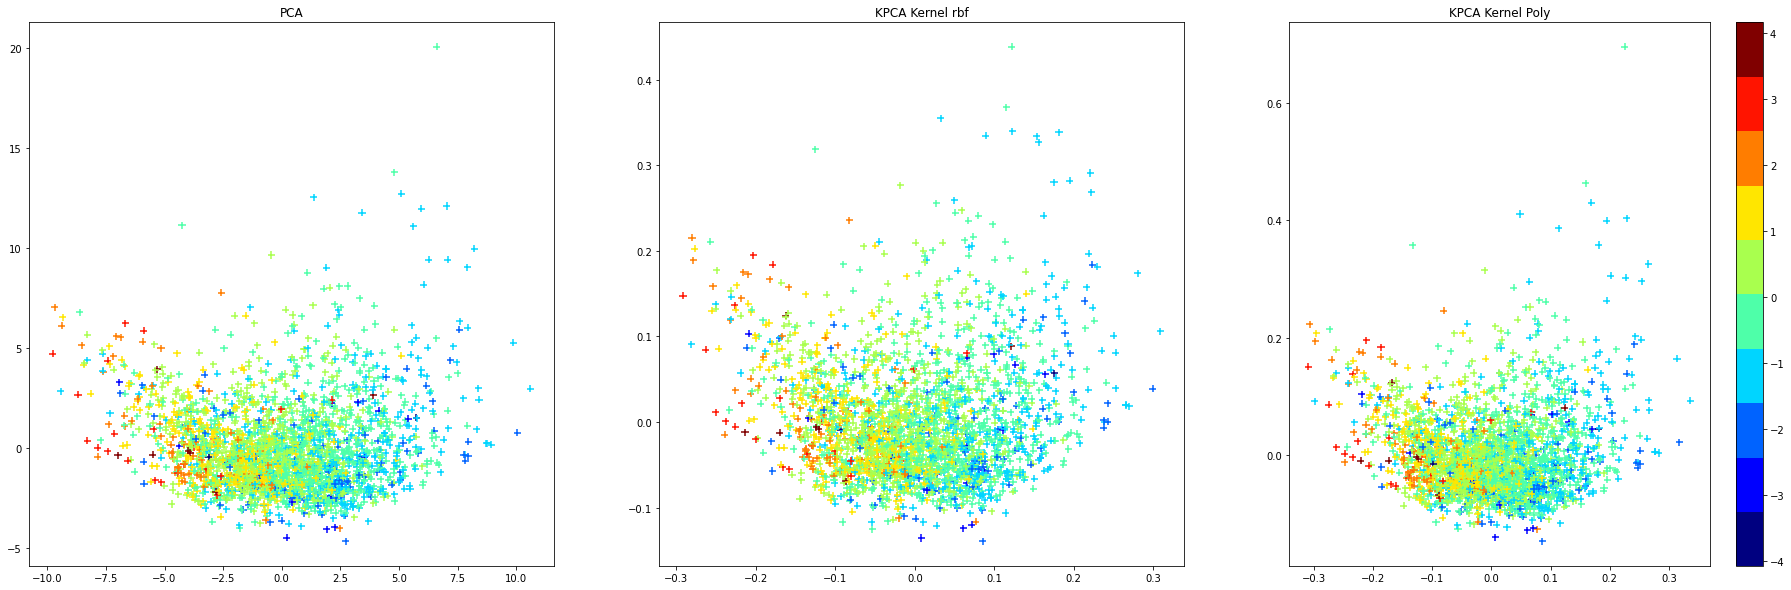

In [8]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


In [9]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

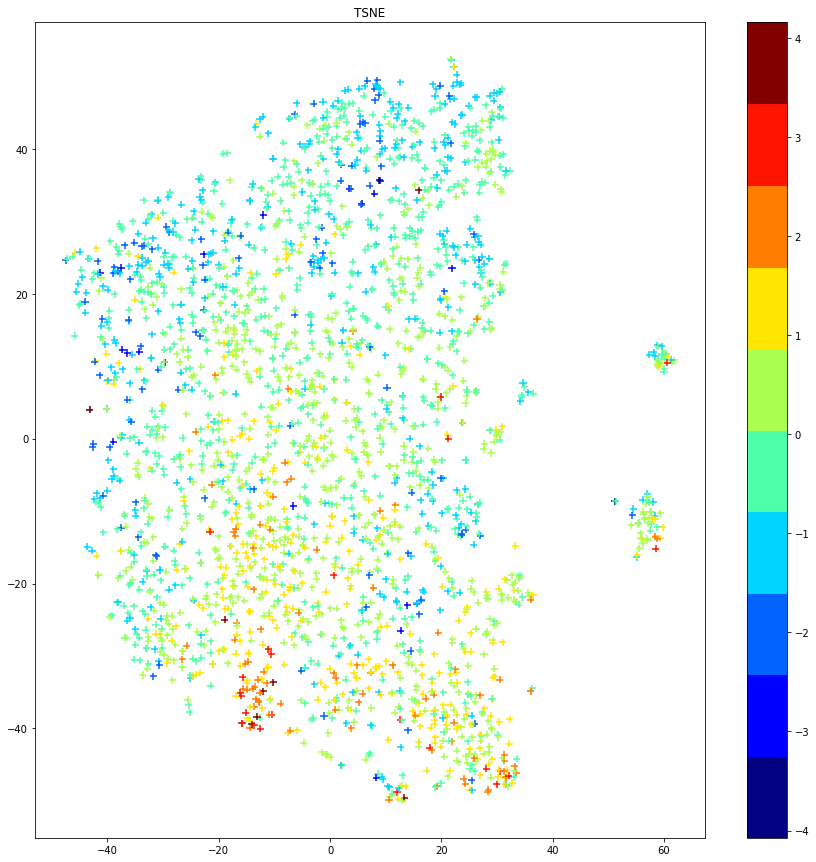

In [10]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

### Quitar outliers

* Usamos [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)


In [11]:
clf = OneClassSVM(gamma='auto', nu=0.2).fit(X)
y_out = clf.fit_predict(X)
y_te_out = clf.predict(X_te)

print('Before tr: ', X.shape)
print('Before te: ', X_te.shape)

Before tr:  (2437, 31)
Before te:  (610, 31)


In [12]:
#train sin outliers
X = X[y_out>0]
y = y[y_out>0]

#test sin outliers
X_te_ = X_te[y_te_out>0]
y_te_ = y_te[y_te_out>0]

print('After tr: ', X.shape)
print('After te: ', X_te_.shape)

After tr:  (1948, 31)
After te:  (476, 31)


In [13]:
X_train = X.copy()
y_train = y.copy()
X_test = X_te_.copy()
y_test = y_te_.copy()

### Como quedan los datos
Visualizacion - PCA - Kernel PCA y t-SNE

In [14]:
x_pc = pc.transform(X)
x_kpc = kpc.transform(X)
x_kpc2 = kpc2.transform(X)

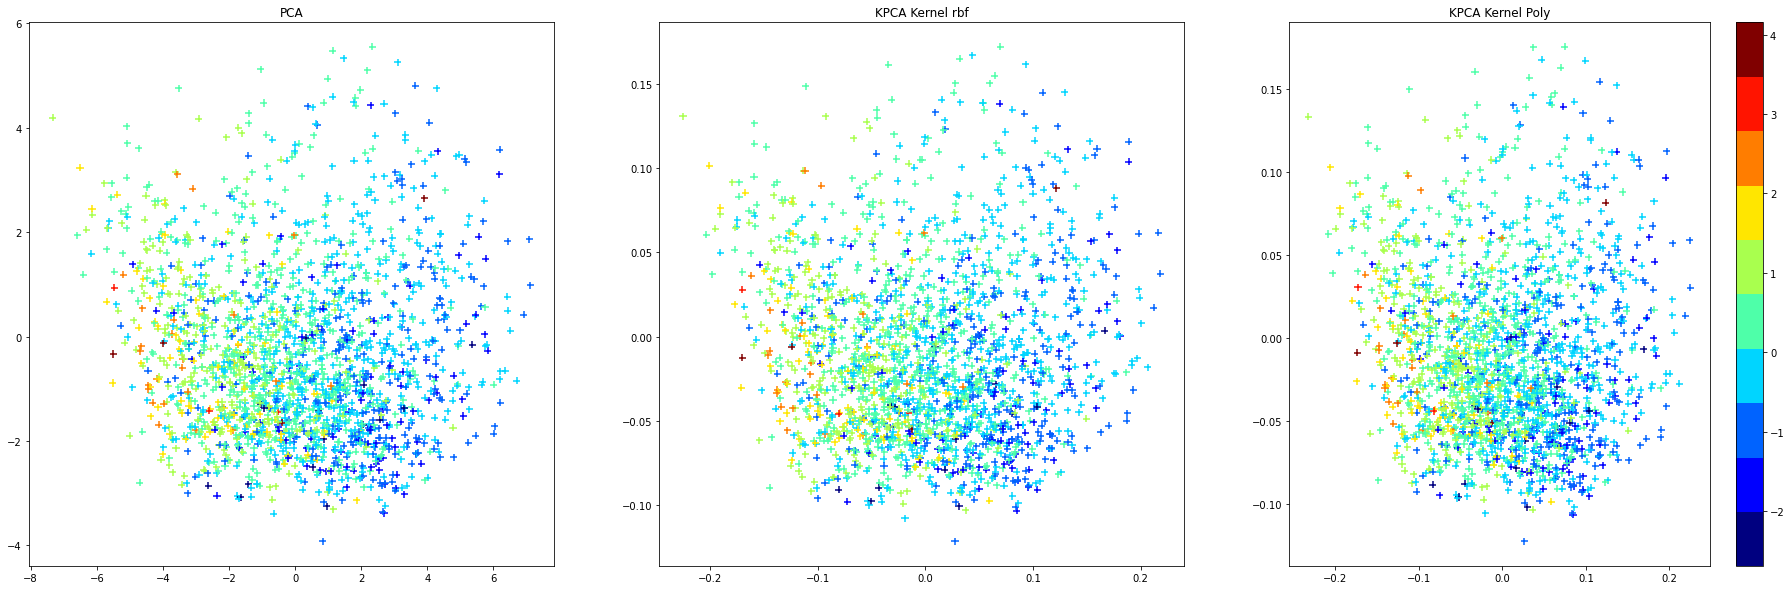

In [15]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


### TSNE

In [16]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

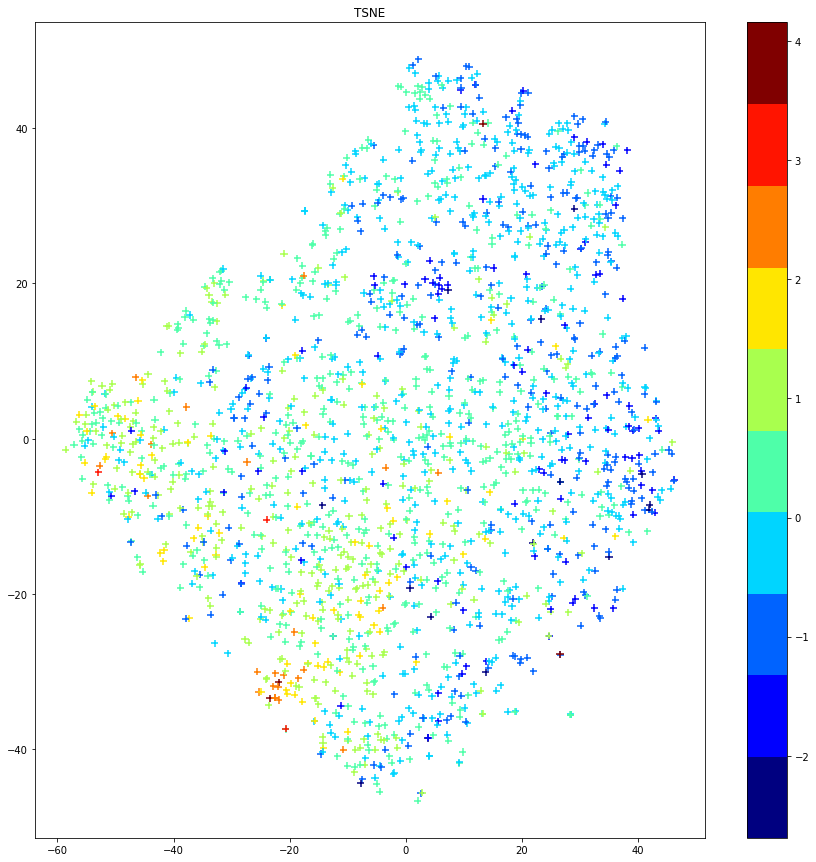

In [17]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

________________

##  Entrenamos 5 modelos de regresion usamos 
[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) y [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 

* [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) 
    - Lin
    - poly
    - rbf
* [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 
* [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) 
* [GBM](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
* [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Tenemos   
X = dataset train sin outliers  
y = variables respuesta de train sin outliers  
y_te = variable respuesta de test con outliers  
y_te_ = variable respuesta de test sin outliers  

In [18]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=2, coef0=1)

In [19]:
results_in_color = []

results_in_color_x = []
results_in_color_x.append('Train w/o outliers')
results_in_color_x.append('Test w outliers')
results_in_color_x.append('Test w/o outliers')

results_in_color_y = []

### SVR rbf

In [20]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_rbf.fit(X, y)
print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_rbf.predict(X)-y)**2)))
print('Test con outliers ', np.sqrt(np.mean((tunner_svr_rbf.predict(X_te)-y_te)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_rbf.predict(X_te_)-y_te_)**2)))
print('R2 train test ')
print('Train ', tunner_svr_rbf.score(X, y))
print('Test con outliers ', tunner_svr_rbf.score(X_te, y_te))
print('Test sin outliers ', tunner_svr_rbf.score(X_te_, y_te_))

results_in_color.append([tunner_svr_rbf.score(X, y), tunner_svr_rbf.score(X_te, y_te), tunner_svr_rbf.score(X_te_, y_te_)])
results_in_color_y.append('SVR rbf')

RMSE train test
Train 0.5537571525021414
Test con outliers  0.7519359718520526
Test sin outliers  0.5852298649319223
R2 train test 
Train  0.6088994142615884
Test con outliers  0.4519737781264581
Test sin outliers  0.5392087924651519


### SVR lin

In [21]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X, y)
print('RMSE train test')
print('Train',np.sqrt(np.mean((tunner_svr_lin.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((tunner_svr_lin.predict(X_te)-y_te)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_lin.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train',tunner_svr_lin.score(X, y))
print('Test con outliers ',tunner_svr_lin.score(X_te, y_te))
print('Test sin outliers ', tunner_svr_lin.score(X_te_, y_te_))
results_in_color.append([tunner_svr_lin.score(X, y), tunner_svr_lin.score(X_te, y_te), tunner_svr_lin.score(X_te_, y_te_)])
results_in_color_y.append('SVR lin')

RMSE train test
Train 0.6367006724650865
Test con outliers  0.7352103604197826
Test sin outliers  0.6135515435991391
R2 train test
Train 0.48296447271366494
Test con outliers  0.47608256309467756
Test sin outliers  0.49353046300603964


### SVR poly

In [22]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X, y)
print('RMSE train test')
print('Train',np.sqrt(np.mean((tunner_svr_poly.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((tunner_svr_poly.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((tunner_svr_poly.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train',tunner_svr_poly.score(X, y))
print('Test con outliers ',tunner_svr_poly.score(X_te, y_te))
print('Test sin outliers ',tunner_svr_poly.score(X_te_, y_te_))
results_in_color.append([tunner_svr_poly.score(X, y), tunner_svr_poly.score(X_te, y_te), tunner_svr_poly.score(X_te_, y_te_)])
results_in_color_y.append('SVR poly')

RMSE train test
Train 0.5791390935628119
Test con outliers  1.3166513773274886
Test sin outliers  0.5825337002142338
R2 train test
Train 0.5722248689741681
Test con outliers  -0.6802782722447904
Test sin outliers  0.5434447594308819


### Ridge reg.

In [23]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X, y)
print('RMSE train test')
print('Train',np.sqrt(np.mean((tunner_lmr.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((tunner_lmr.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((tunner_lmr.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train',tunner_lmr.score(X, y))
print('Test con outliers ',tunner_lmr.score(X_te, y_te))
print('Test sin outliers ',tunner_lmr.score(X_te_, y_te_))
results_in_color.append([tunner_lmr.score(X, y), tunner_lmr.score(X_te, y_te), tunner_lmr.score(X_te_, y_te_)])
results_in_color_y.append('Ridge reg.')

RMSE train test
Train 0.632803416147523
Test con outliers  0.7509903424679271
Test sin outliers  0.6077083910620604
R2 train test
Train 0.48927466861941227
Test con outliers  0.45335129923743533
Test sin outliers  0.5031312438448552


### Lasso reg.

In [24]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X, y)
print('RMSE train test')
print('Train',np.sqrt(np.mean((tunner_lml.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((tunner_lml.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((tunner_lml.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train',tunner_lml.score(X, y))
print('Test con outliers ',tunner_lml.score(X_te, y_te))
print('Test sin outliers ',tunner_lml.score(X_te_, y_te_))
results_in_color.append([tunner_lml.score(X, y), tunner_lml.score(X_te, y_te), tunner_lml.score(X_te_, y_te_)])
results_in_color_y.append('Lasso reg.')

RMSE train test
Train 0.6327117254491063
Test con outliers  1.2272036086235687
Test sin outliers  0.6080611743860599
R2 train test
Train 0.4894226620356543
Test con outliers  -0.4597311080921147
Test sin outliers  0.5025541977080485


### 5-CV Error

(-0.05, 0.7)

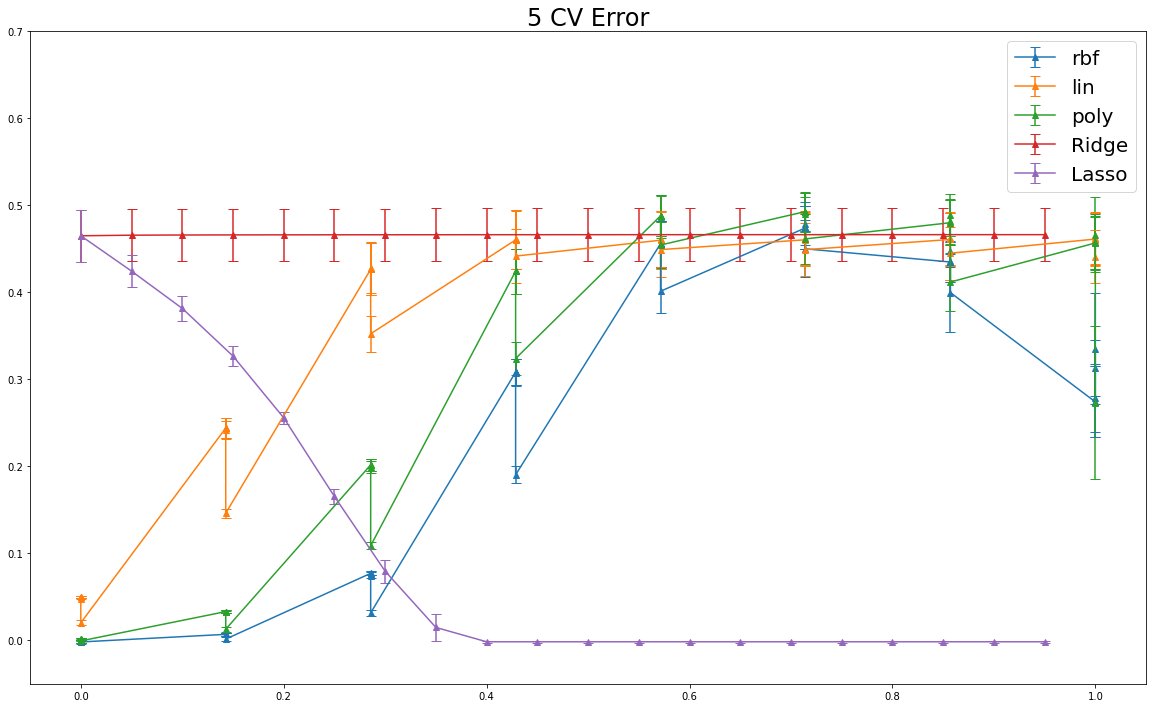

In [25]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* Ridge
* SVR Lineal

In [26]:
result_lmr = permutation_importance(tunner_lmr, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_lmr = result_lmr.importances_mean.argsort()

result_svr_lin = permutation_importance(tunner_svr_rbf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_lin = result_svr_lin.importances_mean.argsort()

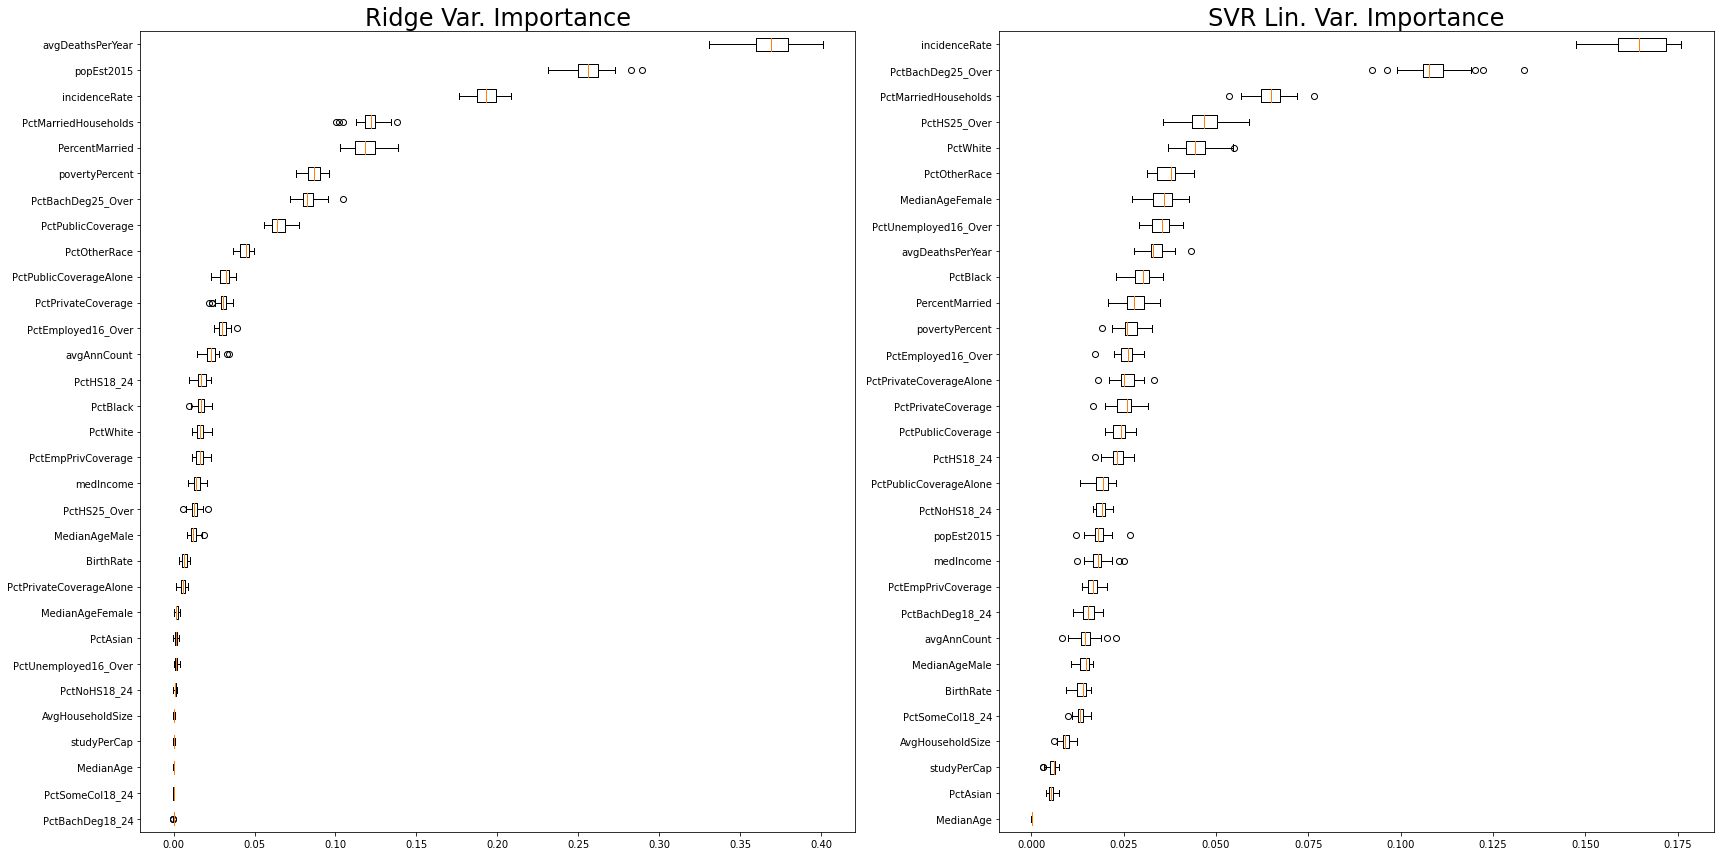

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_lmr.importances[perm_sorted_idx_lmr].T, vert=False, labels=df.columns[perm_sorted_idx_lmr])
ax[0].set_title("Ridge Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_lin.importances[perm_sorted_idx_svr_lin].T, vert=False, labels=df.columns[perm_sorted_idx_svr_lin])
ax[1].set_title("SVR Lin. Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()


## GBM OOB J=6

In [28]:
gbm = GradientBoostingRegressor(learning_rate=0.02, 
                                n_estimators=1000, 
                                subsample=0.6, 
                                max_depth=6)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  273  oob_improvement_:  -0.37748714878083267


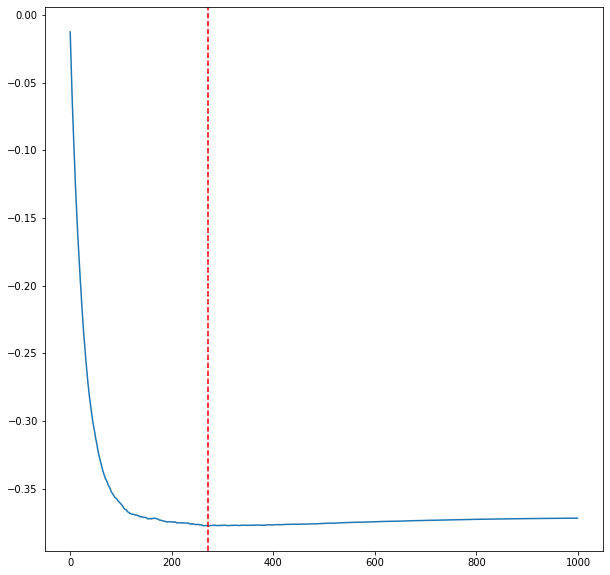

In [29]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [30]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train', gbm.score(X, y))
print('Test con outliers ',gbm.score(X_te, y_te))
print('Test sin outliers ',gbm.score(X_te_, y_te_))
results_in_color.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y.append('GBM J=6 reg.')

0.37910697416056816
RMSE train test
Train 0.2780189474773787
Test con outliers  0.664715626293977
Test sin outliers  0.5472357341481191
R2 train test
Train 0.9014177880215021
Test con outliers  0.5717361737953046
Test sin outliers  0.5970973534916881


## GBM OOB J=4

In [31]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X, y)


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  319  oob_improvement_:  -0.3702724721585894


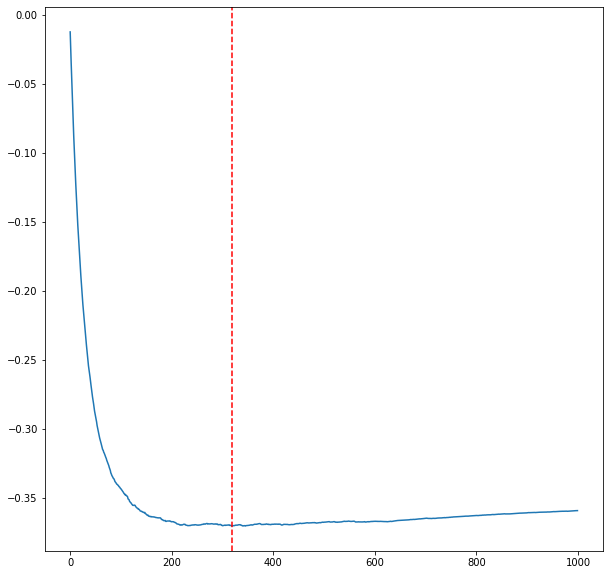

In [32]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [33]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train', gbm.score(X, y))
print('Test con outliers ',gbm.score(X_te, y_te))
print('Test sin outliers ',gbm.score(X_te_, y_te_))
results_in_color.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y.append('GBM J=4 reg.')

0.3668544479713799
RMSE train test
Train 0.4148994261970202
Test con outliers  0.6622666759778219
Test sin outliers  0.5464048393572011
R2 train test
Train 0.7804489910339758
Test con outliers  0.5748859864326998
Test sin outliers  0.5983199182503147


### RF reg.

In [34]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X, y) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X, y)
print('RMSE train test')
print('Train', np.sqrt(np.mean((rf.predict(X)-y)**2)))
print('Test con outliers ',np.sqrt(np.mean((rf.predict(X_te)-y_te)**2)))
print('Test sin outliers ',np.sqrt(np.mean((rf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print('Train', rf.score(X, y))
print('Test con outliers ',rf.score(X_te, y_te))
print('Test sin outliers ',rf.score(X_te_, y_te_))
results_in_color.append([rf.score(X, y), rf.score(X_te, y_te), rf.score(X_te_, y_te_)])
results_in_color_y.append('RF Reg.')

[0.50517767 0.50303304 0.50395957]
RMSE train test
Train 0.23010082176689667
Test con outliers  0.6997636577376939
Test sin outliers  0.5901886022620458
R2 train test
Train 0.9324716546612719
Test con outliers  0.5253839908204587
Test sin outliers  0.5313670091790355


### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* GBM
* RF

In [35]:
result_gbm = permutation_importance(gbm, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_gbm = result_gbm.importances_mean.argsort()
result_svr_rf = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_rf = result_svr_rf.importances_mean.argsort()

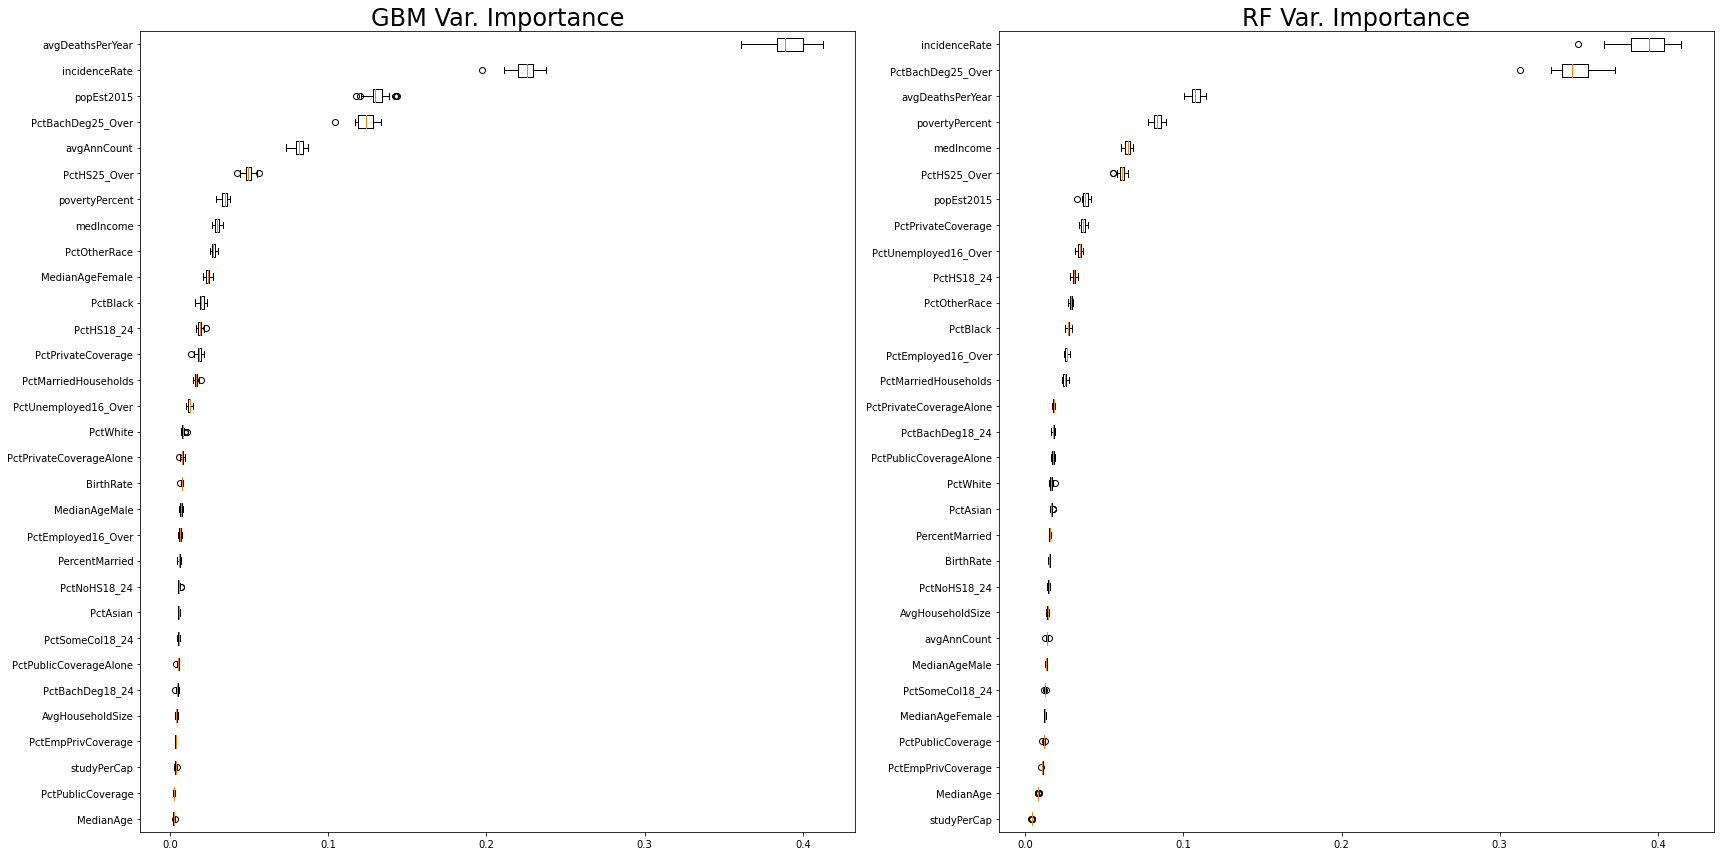

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_gbm.importances[perm_sorted_idx_gbm].T, vert=False, labels=df.columns[perm_sorted_idx_gbm])
ax[0].set_title("GBM Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_rf.importances[perm_sorted_idx_svr_rf].T, vert=False, labels=df.columns[perm_sorted_idx_svr_rf])
ax[1].set_title("RF Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()

### Results in color

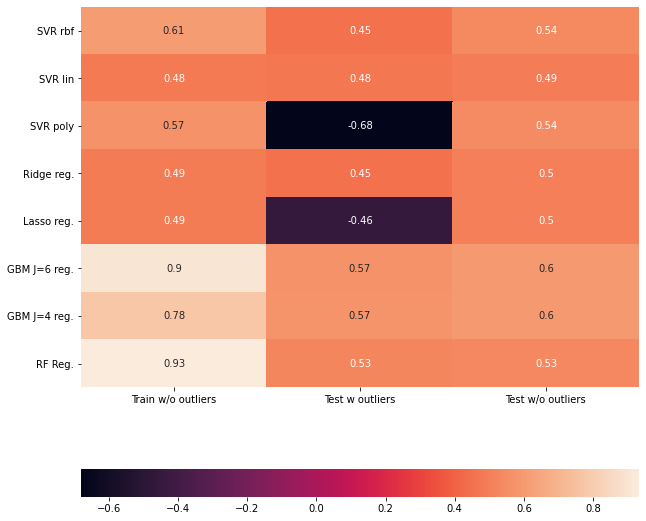

In [37]:
results_in_color = np.array(results_in_color)
results_in_color_x = np.array(results_in_color_x)
results_in_color_y = np.array(results_in_color_y)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(results_in_color, annot=True, ax=ax, yticklabels=results_in_color_y, xticklabels=results_in_color_x, 
                 cbar_kws={"orientation": "horizontal"})

________________________________

## Entrenamos 5 modelos sacando las variables correlacionadas

### Dendogram + Pearson absolute distance

(31, 31) 0.01550004991402143 1.0
(31, 31) 0.0 0.9989547480545029


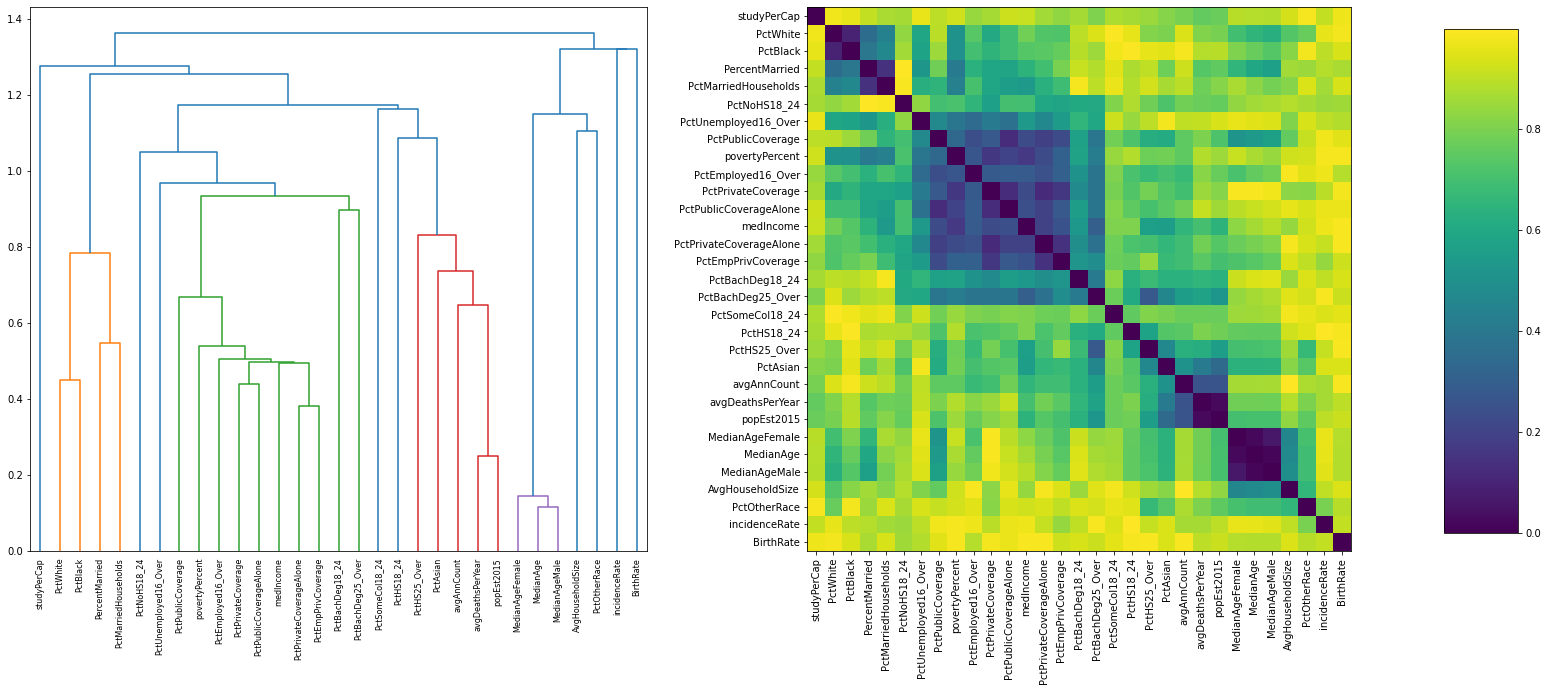

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
# corr = spearmanr(X).correlation
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
print(d.shape, d.min(), d.max())
np.fill_diagonal(d, 0.)
print(d.shape, d.min(), d.max())
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()

### Cut clusters < 0.5 

In [39]:
L = hierarchy.fcluster(corr_linkage, 0.5, criterion='distance')
print(np.unique(L).size, L.size)

23 31


In [40]:
feat_id = np.arange(0, X.shape[1], dtype=np.int32)
feat_list = []
for feat in np.unique(L):
    bool_f = L==feat
    sb = bool_f.sum()
    if sb > 2:
#         corr = spearmanr(X[:, bool_f]).correlation
        corr = squareform(pdist(X[:, bool_f].T, 'correlation'))
        d = 1-np.abs(corr)
        feat_red = feat_id[bool_f]
        i_min = feat_red[d.sum(axis=1).argmin()]
        feat_list.append(feat_id[i_min])
    elif sb == 2:
        feat_list.append(feat_id[bool_f].min())
    else:
        feat_list.append(feat_id[bool_f])
feat_list = np.hstack(feat_list)

In [41]:
X = X[:,feat_list]
X_te = X_te[:,feat_list]
X_ = X_[:,feat_list]
X_te_ = X_te_[:,feat_list]

### Clustering results 

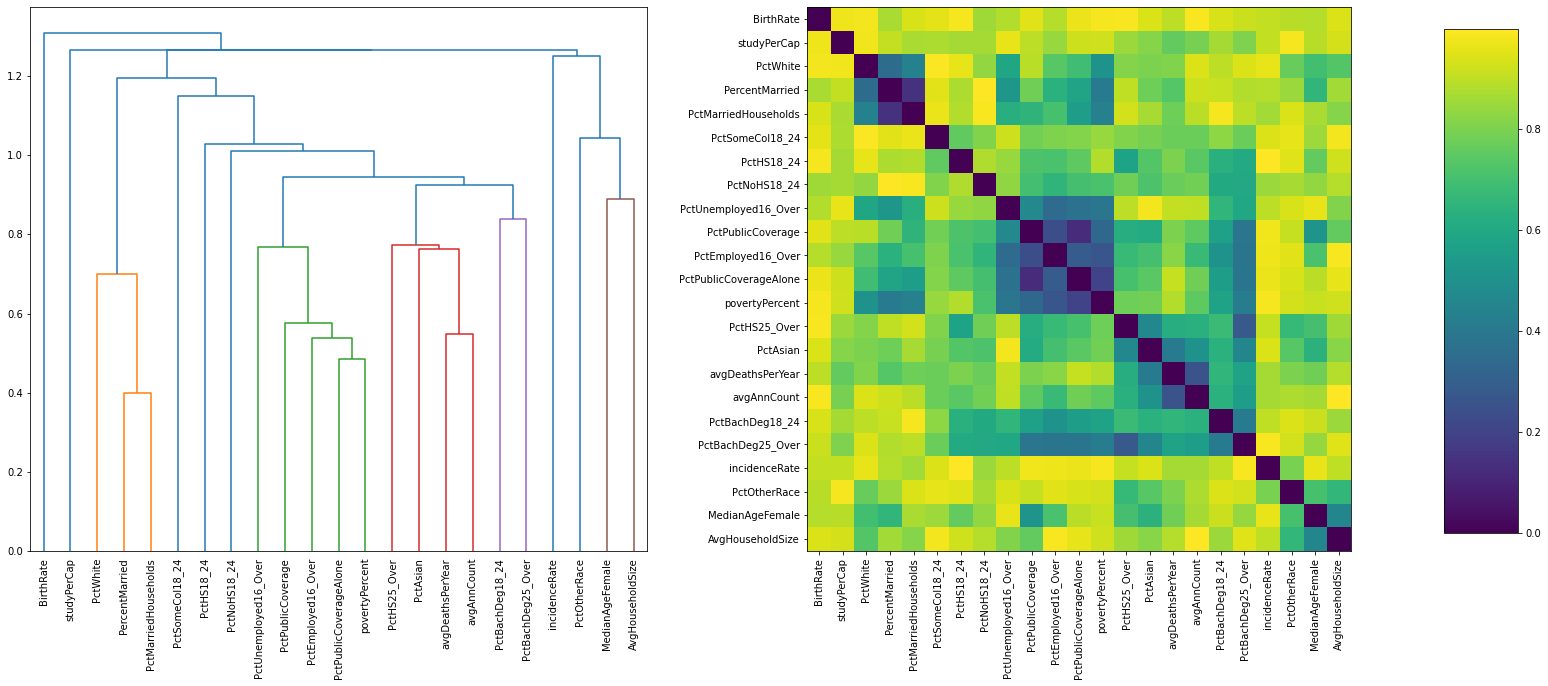

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
np.fill_diagonal(d, 0.)
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.iloc[:, feat_list].columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()


### Recluster

In [43]:
L = hierarchy.fcluster(corr_linkage, 0.5, criterion='distance')
print(np.unique(L).size, L.size)

21 23


In [44]:
feat_id = np.arange(0, X.shape[1], dtype=np.int32)
feat_list = []
for feat in np.unique(L):
    bool_f = L==feat
    sb = bool_f.sum()
    if sb > 2:
#         corr = spearmanr(X[:, bool_f]).correlation
        corr = squareform(pdist(X[:, bool_f].T, 'correlation'))
        d = 1-np.abs(corr)
        feat_red = feat_id[bool_f]
        i_min = feat_red[d.sum(axis=1).argmin()]
        feat_list.append(feat_id[i_min])
    elif sb == 2:
        feat_list.append(feat_id[bool_f].min())
    else:
        feat_list.append(feat_id[bool_f])
feat_list = np.hstack(feat_list)

In [45]:
X = X[:,feat_list]
X_te = X_te[:,feat_list]
X_ = X_[:,feat_list]
X_te_ = X_te_[:,feat_list]

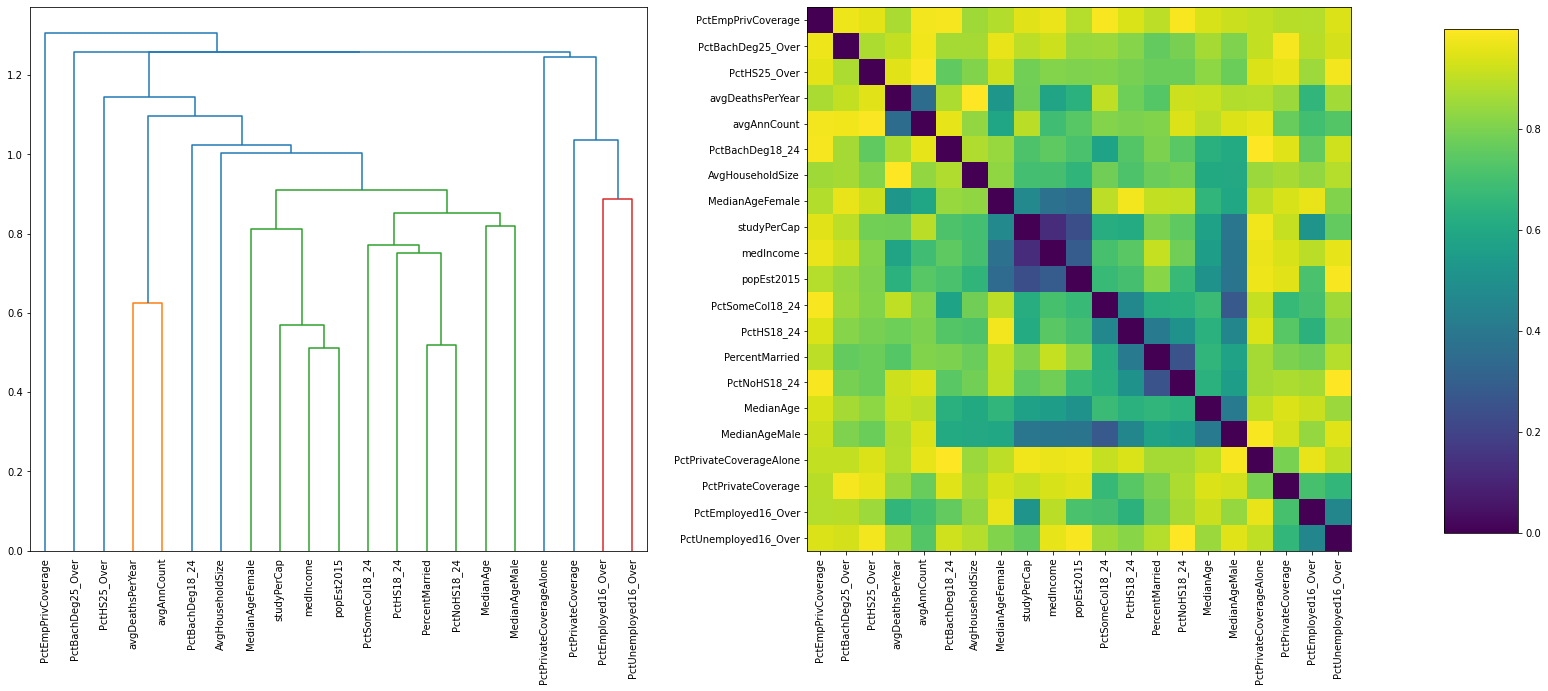

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
np.fill_diagonal(d, 0.)
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.iloc[:, feat_list].columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()


### PCA de los datos resultantes

In [47]:
pc = PCA(n_components=2)
x_pc = pc.fit_transform(X)

kpc = KernelPCA(n_components=2, kernel='rbf', degree=3, gamma=0.0005, fit_inverse_transform=True)
x_kpc = kpc.fit_transform(X)

kpc2 = KernelPCA(n_components=2, kernel='poly', degree=2, gamma=0.0005, fit_inverse_transform=True)
x_kpc2 = kpc2.fit_transform(X)

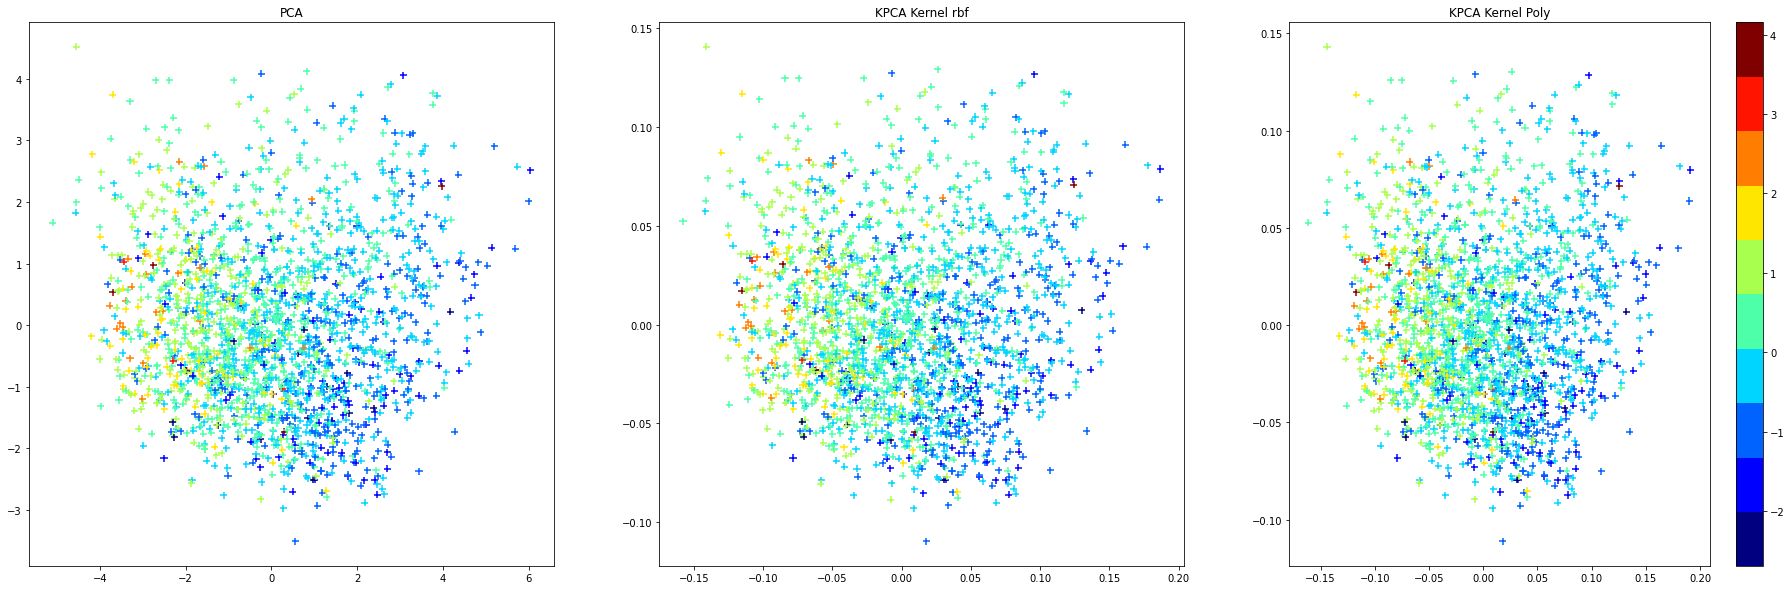

In [48]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


### TSNE

In [49]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

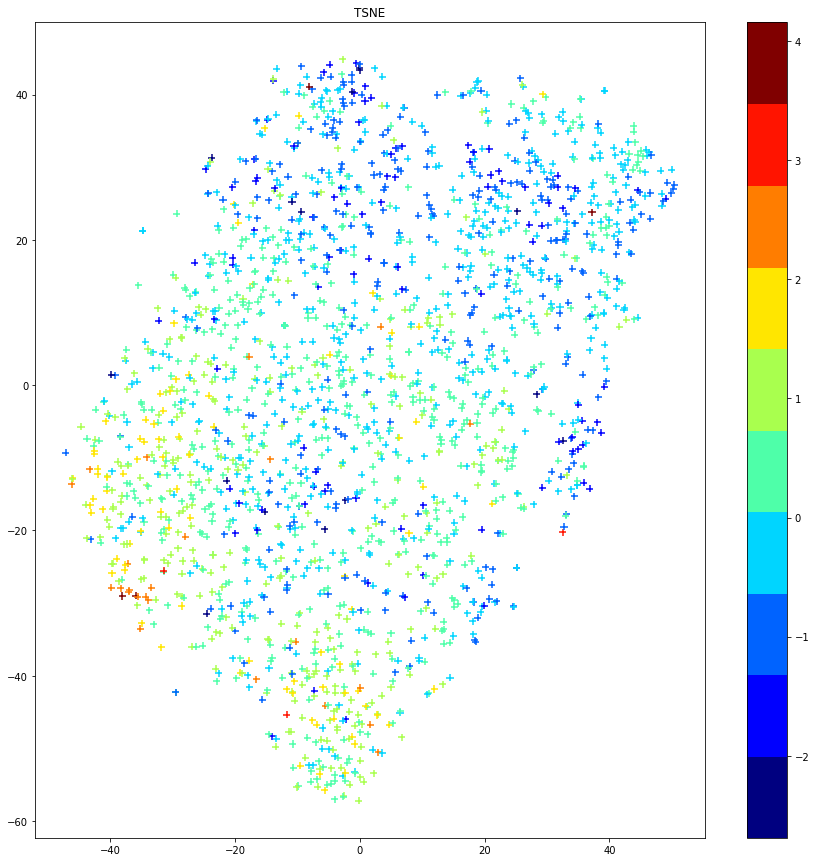

In [50]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

In [51]:
results_in_color_2 = []

results_in_color_x_2 = []
results_in_color_x_2.append('Train w/o outliers')
results_in_color_x_2.append('Test w outliers')
results_in_color_x_2.append('Test w/o outliers')

results_in_color_y_2 = []

In [52]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=3, coef0=1)

### SVR rbf

In [53]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_rbf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_rbf.score(X, y))
print(tunner_svr_rbf.score(X_te, y_te))
print(tunner_svr_rbf.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_rbf.score(X, y), tunner_svr_rbf.score(X_te, y_te), tunner_svr_rbf.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR rbf')

RMSE train test
0.5666154456178045
0.761111639691479
0.5915715459990113
R2 train test
0.5905257587755328
0.4385173469676268
0.5291682124875636


### SVR lin.

In [54]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_lin.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_lin.score(X, y))
print(tunner_svr_lin.score(X_te, y_te))
print(tunner_svr_lin.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_lin.score(X, y), tunner_svr_lin.score(X_te, y_te), tunner_svr_lin.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR lin')

RMSE train test
0.6507674569590842
0.6973469342074406
0.6178267147559446
R2 train test
0.4598661156782953
0.5286566243208987
0.48644780600628945


### SVR poly

In [55]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_poly.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_poly.score(X, y))
print(tunner_svr_poly.score(X_te, y_te))
print(tunner_svr_poly.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_poly.score(X, y), tunner_svr_poly.score(X_te, y_te), tunner_svr_poly.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR poly.')

RMSE train test
0.600101188960183
2.021761886563737
0.595413677001735
R2 train test
0.5406975697875465
-2.961864574268444
0.5230324476885746


### Ridge reg.

In [56]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lmr.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lmr.score(X, y))
print(tunner_lmr.score(X_te, y_te))
print(tunner_lmr.score(X_te_, y_te_))
results_in_color_2.append([tunner_lmr.score(X, y), tunner_lmr.score(X_te, y_te), tunner_lmr.score(X_te_, y_te_)])
results_in_color_y_2.append('Ridge reg.')

RMSE train test
0.647781023553204
0.6959877125813799
0.621497886434828
R2 train test
0.46481219152855613
0.5304922550876883
0.48032654373570416


### Lasso reg.

In [57]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lml.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lml.score(X, y))
print(tunner_lml.score(X_te, y_te))
print(tunner_lml.score(X_te_, y_te_))
results_in_color_2.append([tunner_lml.score(X, y), tunner_lml.score(X_te, y_te), tunner_lml.score(X_te_, y_te_)])
results_in_color_y_2.append('Lasso reg.')

RMSE train test
0.6477800641258479
0.6962529535970661
0.6216080066760232
R2 train test
0.46481377685886127
0.5301343279616819
0.4801423705069717


### Revisamos los modelos nuevamente

(-0.05, 0.7)

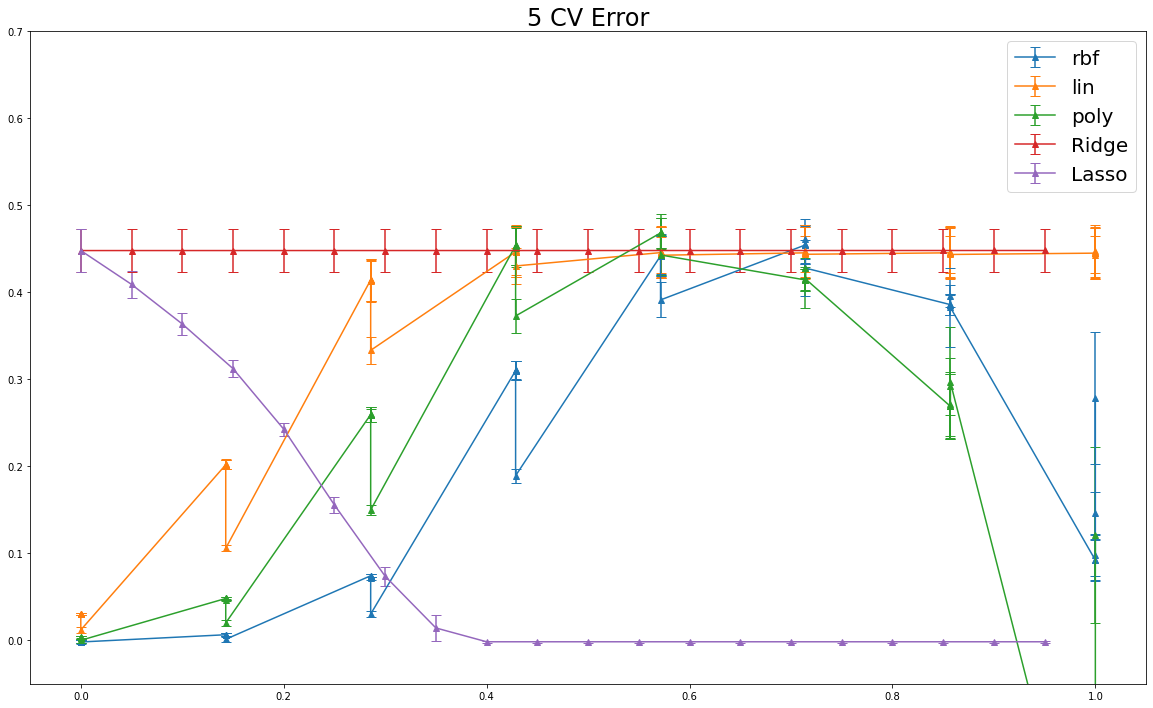

In [58]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* Ridge
* SVR Lineal

In [59]:
result_lmr = permutation_importance(tunner_lmr, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_lmr = result_lmr.importances_mean.argsort()

result_svr_lin = permutation_importance(tunner_svr_rbf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_lin = result_svr_lin.importances_mean.argsort()

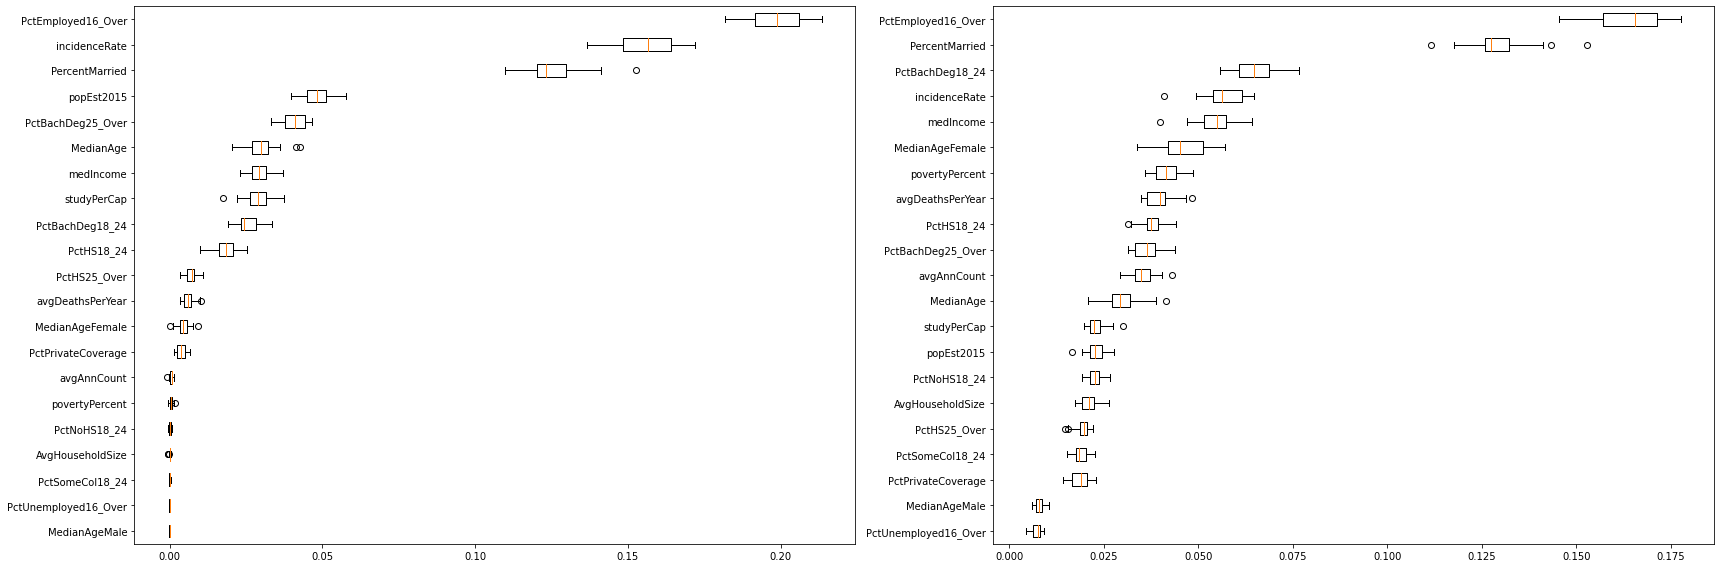

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].boxplot(result_lmr.importances[perm_sorted_idx_lmr].T, vert=False, labels=df.columns[perm_sorted_idx_lmr])
ax[1].boxplot(result_svr_lin.importances[perm_sorted_idx_svr_lin].T, vert=False, labels=df.columns[perm_sorted_idx_svr_lin])
fig.tight_layout()
plt.show()


## GBM OOB J=6

In [61]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=6)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  232  oob_improvement_:  -0.36338313903851116


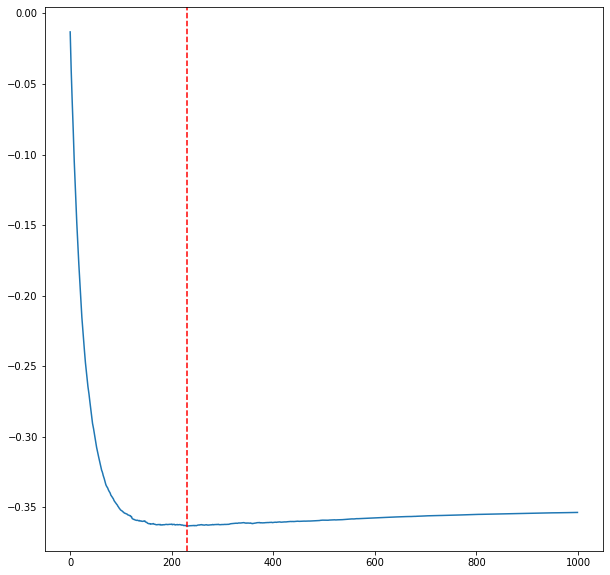

In [62]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [63]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color_2.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y_2.append('GBM J=6 reg.')

0.35371550775798577
RMSE train test
0.32918963829873216
0.6892013744866606
0.5649144987832843
R2 train test
0.8617891676810503
0.5396036352972244
0.570644861378697


## GBM OOB J=4

In [64]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  251  oob_improvement_:  -0.3405012173376306


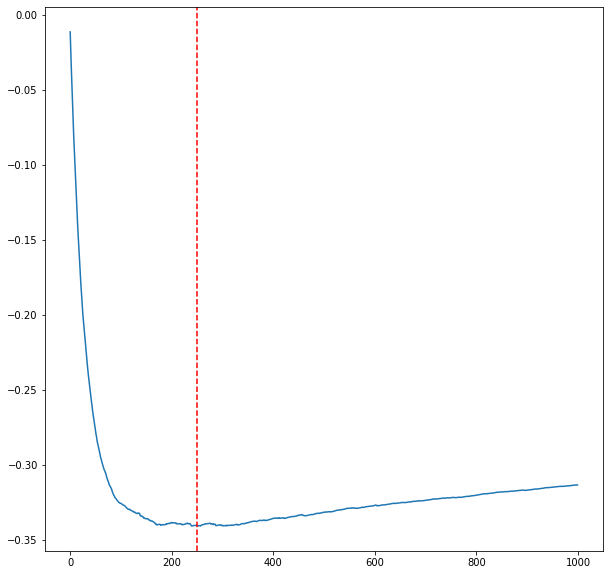

In [65]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [66]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color_2.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y_2.append('GBM J=4 reg.')

0.3432658548401611
RMSE train test
0.46663437918812245
0.6976040910429896
0.5792668040954827
R2 train test
0.7222825088547568
0.5283089307588478
0.5485511979580773


### RF reg.

In [67]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X, y) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((rf.predict(X)-y)**2)))
print(np.sqrt(np.mean((rf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((rf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(rf.score(X, y))
print(rf.score(X_te, y_te))
print(rf.score(X_te_, y_te_))
results_in_color_2.append([rf.score(X, y), rf.score(X_te, y_te), rf.score(X_te_, y_te_)])
results_in_color_y_2.append('RF reg.')

[0.47525562 0.47993449 0.47963038]
RMSE train test
0.234964769298355
0.7075676450513849
0.6050380465630228
R2 train test
0.9295866078859991
0.5147388228557122
0.507488253507389


### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* GBM
* RF

In [68]:
result_gbm = permutation_importance(gbm, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_gbm = result_gbm.importances_mean.argsort()
result_svr_rf = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_rf = result_svr_rf.importances_mean.argsort()

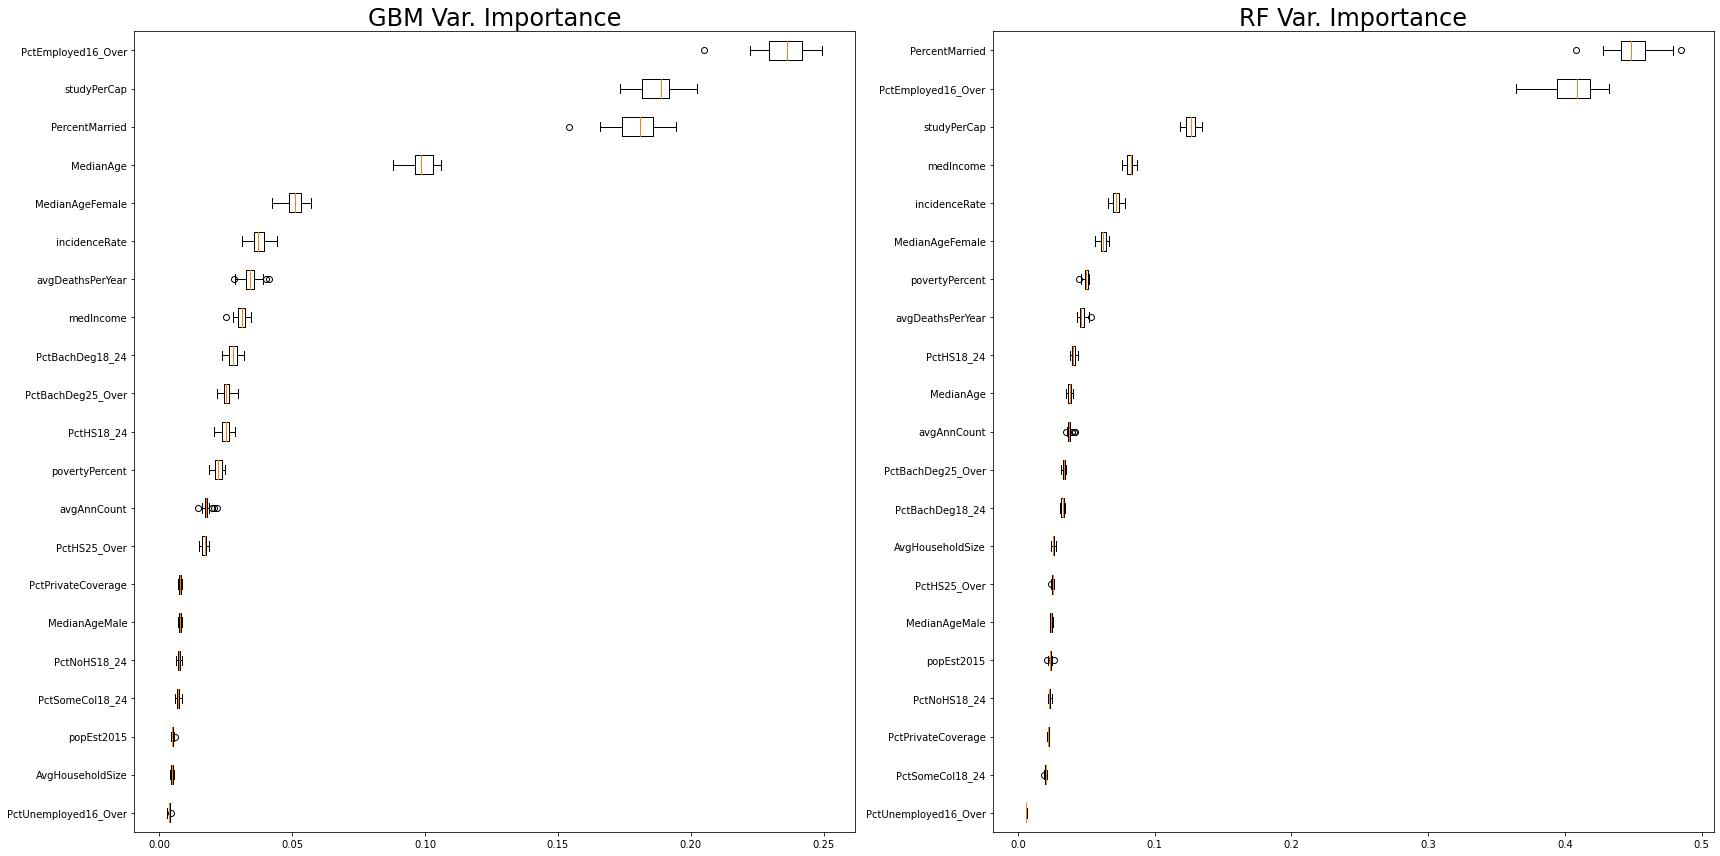

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_gbm.importances[perm_sorted_idx_gbm].T, vert=False, labels=df.columns[perm_sorted_idx_gbm])
ax[0].set_title("GBM Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_rf.importances[perm_sorted_idx_svr_rf].T, vert=False, labels=df.columns[perm_sorted_idx_svr_rf])
ax[1].set_title("RF Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()

Text(0.5, 1.0, '21 variables')

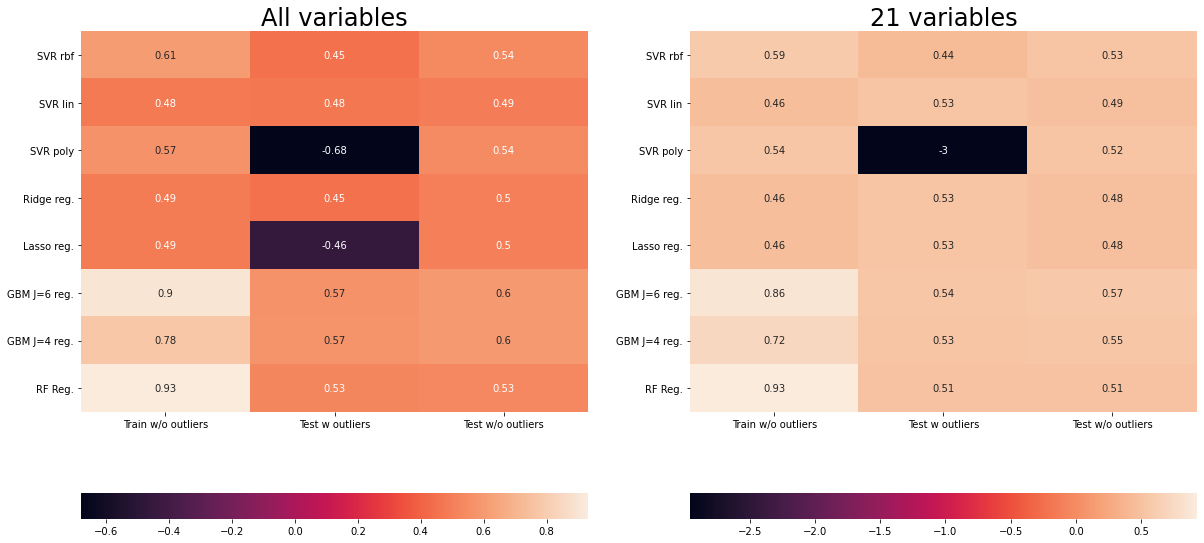

In [70]:
results_in_color_2 = np.array(results_in_color_2)
results_in_color_x_2 = np.array(results_in_color_x_2)
results_in_color_y_2 = np.array(results_in_color_y_2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0] = sns.heatmap(results_in_color, annot=True, ax=ax[0], yticklabels=results_in_color_y, xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"})
ax[0].set_title('All variables', fontsize=24)



ax[1] = sns.heatmap(results_in_color_2, annot=True, ax=ax[1], yticklabels=results_in_color_y, xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"})
ax[1].set_title('21 variables', fontsize=24)

__________________________________________________________________

## Entrenamos 5 modelos usando PCA con 21 componentes

Lo realizaremos sin outliers ya que PCA es un método muy sensible a los valores extremos.

In [71]:
pc = PCA(n_components=21)
X_train_pca = pc.fit_transform(X_train)
X_test_pca = pc.transform(X_test)

print(pc.explained_variance_ratio_.sum())


0.9798872286716712


In [72]:
X_train_pca

array([[-2.57905764,  1.22849249, -0.66606355, ...,  0.63621004,
         0.68115474, -0.34438013],
       [ 0.49243734, -1.06515866, -0.38567472, ...,  0.09146651,
         0.35043425, -0.07967145],
       [ 2.09947836, -0.57816505, -0.26010773, ...,  0.0063636 ,
         0.59073614,  0.25801395],
       ...,
       [-2.65856521, -0.97563842, -1.40062724, ..., -0.40398535,
         0.70276294, -0.02676928],
       [-4.48116707,  2.74408341, -0.59438358, ..., -0.20268548,
         0.27253836, -0.55464471],
       [-1.87108298, -0.51239999, -0.96071565, ..., -0.09987703,
         0.47362811, -0.02349231]])

Tenemos   
X_train_pca  
X_test_pca

In [73]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=2, coef0=1)

In [74]:
results_in_color_pca21 = []

results_in_color_pca21_x = []
results_in_color_pca21_x.append('Train w/o outliers')
results_in_color_pca21_x.append('Test w/o outliers')

results_in_color_pca21_y = []

### SVR rbf

In [75]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)

cv = KFold(n_splits=5, random_state=0, shuffle=True)

tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, 
                              param_grid={'C':par, 'epsilon':eps}, 
                              cv=cv, 
                              n_jobs=12)
_=tunner_svr_rbf.fit(X_train_pca, y_train)


In [76]:
print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_rbf.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_rbf.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_rbf.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_rbf.score(X_test_pca, y_test))

results_in_color_pca21.append([tunner_svr_rbf.score(X_train_pca, y_train), tunner_svr_rbf.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('SVR rbf')

RMSE train test
Train 0.5372727485523177
Test sin outliers  0.5956070069923024
R2 train test 
Train  0.6318376319715558
Test sin outliers  0.5227226560041471


### SVR lin

In [77]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_lin.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_lin.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_lin.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_lin.score(X_test_pca, y_test))

results_in_color_pca21.append([tunner_svr_lin.score(X_train_pca, y_train), tunner_svr_lin.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('SVR lin')

RMSE train test
Train 0.6502845845116552
Test sin outliers  0.6170655715697854
R2 train test 
Train  0.46066738195128654
Test sin outliers  0.4877123870408714


### SVR poly

In [78]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_poly.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_poly.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_poly.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_poly.score(X_test_pca, y_test))

results_in_color_pca21.append([tunner_svr_poly.score(X_train_pca, y_train), tunner_svr_poly.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('SVR poly')

RMSE train test
Train 0.611022427755868
Test sin outliers  0.5890481569489275
R2 train test 
Train  0.5238277615878565
Test sin outliers  0.533176376306566


### Ridge reg.

In [79]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_lmr.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_lmr.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_lmr.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_lmr.score(X_test_pca, y_test))

results_in_color_pca21.append([tunner_lmr.score(X_train_pca, y_train), tunner_lmr.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('Ridge reg.')

RMSE train test
Train 0.6484533041991069
Test sin outliers  0.618515984301176
R2 train test 
Train  0.46370075697097113
Test sin outliers  0.4853012924845601


### Lasso reg.

In [80]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_lmr.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_lmr.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_lmr.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_lmr.score(X_test_pca, y_test))

results_in_color_pca21.append([tunner_lmr.score(X_train_pca, y_train), tunner_lmr.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('Ridge reg.')

RMSE train test
Train 0.6484533041991069
Test sin outliers  0.618515984301176
R2 train test 
Train  0.46370075697097113
Test sin outliers  0.4853012924845601


### 5-CV Error

(-0.05, 0.7)

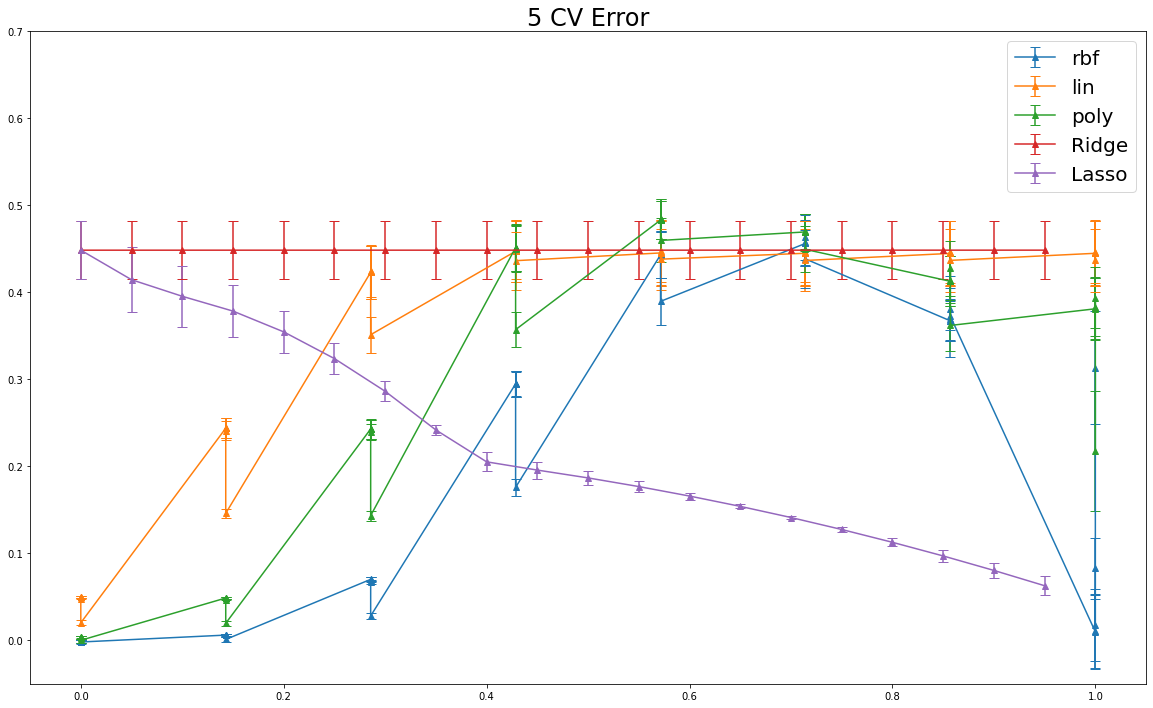

In [81]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

## GBM OOB J=6

In [82]:
gbm = GradientBoostingRegressor(learning_rate=0.02, 
                                n_estimators=1000, 
                                subsample=0.6, 
                                max_depth=6)
gbm.fit(X_train_pca, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  112  oob_improvement_:  -0.3220351051142487


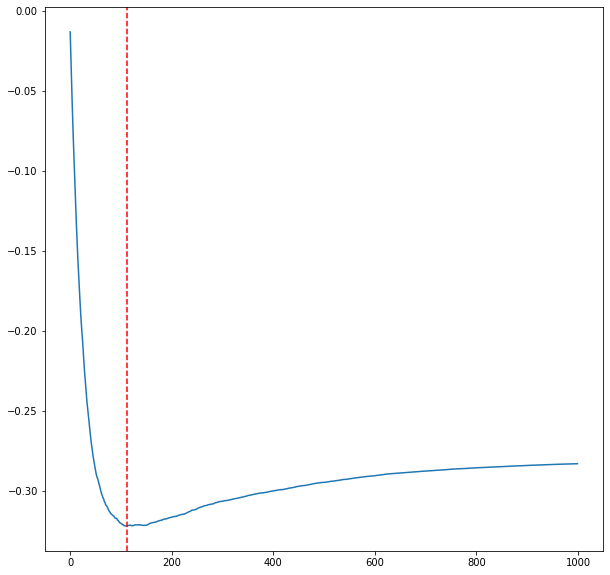

In [83]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [84]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X_train_pca, y_train)
print(gbm.oob_improvement_.sum())


print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', gbm.score(X_train_pca, y_train))
print('Test sin outliers ',gbm.score(X_test_pca, y_test))

results_in_color_pca21.append([gbm.score(X_train_pca, y_train), gbm.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('GBM J=6 reg.')

0.31795298451551623
RMSE train test
Train 0.4638446023848091
Test sin outliers  0.6247528700577797
R2 train test
Train 0.7255932543369795
Test sin outliers  0.4748688964447928


## GBM OOB J=4

In [85]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X_train_pca, y_train)


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  147  oob_improvement_:  -0.3125518187779248


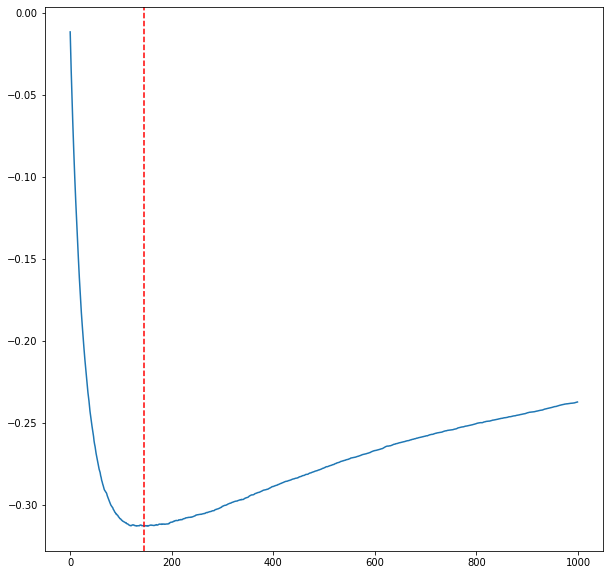

In [86]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [87]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X_train_pca, y_train)
print(gbm.oob_improvement_.sum())



print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', gbm.score(X_train_pca, y_train))
print('Test sin outliers ',gbm.score(X_test_pca, y_test))

results_in_color_pca21.append([gbm.score(X_train_pca, y_train), gbm.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('GBM J=4 reg.')

0.31838489372078155
RMSE train test
Train 0.5481133559322267
Test sin outliers  0.6220495540473251
R2 train test
Train 0.6168308476185247
Test sin outliers  0.47940356633265935


### RF reg.

In [88]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X_train_pca, y_train) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((rf.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((rf.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', rf.score(X_train_pca, y_train))
print('Test sin outliers ',rf.score(X_test_pca, y_test))



results_in_color_pca21.append([rf.score(X_train_pca, y_train), rf.score(X_test_pca, y_test)])
results_in_color_pca21_y.append('RF Reg.')

[0.44750008 0.44620216 0.45131998]
RMSE train test
Train 0.240969382713634
Test sin outliers  0.6199268265807142
R2 train test
Train 0.925941740841053
Test sin outliers  0.4829505468141819


__________________________________________________________________

## Entrenamos 5 modelos usando PCA con todas las componentes

Lo realizaremos sin outliers ya que PCA es un método muy sensible a los valores extremos.

In [90]:
pc = PCA(n_components=31)
X_train_pca = pc.fit_transform(X_train)
X_test_pca = pc.transform(X_test)

print(pc.explained_variance_ratio_.sum())


0.9999999999999999


In [91]:
X_train_pca

array([[-2.57905764e+00,  1.22849249e+00, -6.66063550e-01, ...,
        -4.45370782e-02, -1.97793631e-02,  3.63108327e-03],
       [ 4.92437340e-01, -1.06515866e+00, -3.85674723e-01, ...,
         3.21409345e-02, -8.09841107e-03,  4.34707231e-03],
       [ 2.09947836e+00, -5.78165052e-01, -2.60107728e-01, ...,
         2.63124316e-03, -5.02112140e-02, -1.01743679e-03],
       ...,
       [-2.65856521e+00, -9.75638423e-01, -1.40062724e+00, ...,
         1.94894360e-01,  4.17693894e-03, -8.67207710e-04],
       [-4.48116707e+00,  2.74408341e+00, -5.94383584e-01, ...,
        -1.20035111e-01, -2.56631718e-03, -2.28765175e-03],
       [-1.87108298e+00, -5.12399990e-01, -9.60715650e-01, ...,
         3.40952232e-01,  3.72245224e-02, -4.58276200e-03]])

Tenemos   
X_train_pca  
X_test_pca

In [92]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=2, coef0=1)

In [93]:
results_in_color_pcatodas = []

results_in_color_pcatodas_x = []
results_in_color_pcatodas_x.append('Train w/o outliers')
results_in_color_pcatodas_x.append('Test w/o outliers')

results_in_color_pcatodas_y = []

### SVR rbf

In [94]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)

cv = KFold(n_splits=5, random_state=0, shuffle=True)

tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, 
                              param_grid={'C':par, 'epsilon':eps}, 
                              cv=cv, 
                              n_jobs=12)
_=tunner_svr_rbf.fit(X_train_pca, y_train)


In [95]:
print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_rbf.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_rbf.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_rbf.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_rbf.score(X_test_pca, y_test))

results_in_color_pcatodas.append([tunner_svr_rbf.score(X_train_pca, y_train), tunner_svr_rbf.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('SVR rbf')

RMSE train test
Train 0.5537571525021417
Test sin outliers  0.5852298649319223
R2 train test 
Train  0.608899414261588
Test sin outliers  0.5392087924651519


### SVR lin

In [96]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_lin.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_lin.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_lin.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_lin.score(X_test_pca, y_test))

results_in_color_pcatodas.append([tunner_svr_lin.score(X_train_pca, y_train), tunner_svr_lin.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('SVR lin')

RMSE train test
Train 0.6366943689832067
Test sin outliers  0.6135847727406704
R2 train test 
Train  0.4829747102022851
Test sin outliers  0.4934756020776153


### SVR poly

In [97]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_svr_poly.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_svr_poly.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_svr_poly.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_svr_poly.score(X_test_pca, y_test))

results_in_color_pcatodas.append([tunner_svr_poly.score(X_train_pca, y_train), tunner_svr_poly.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('SVR poly')

RMSE train test
Train 0.5791559010175156
Test sin outliers  0.5826672885069738
R2 train test 
Train  0.5722000393070039
Test sin outliers  0.5432353383163364


### Ridge reg.

In [98]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_lmr.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_lmr.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_lmr.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_lmr.score(X_test_pca, y_test))

results_in_color_pcatodas.append([tunner_lmr.score(X_train_pca, y_train), tunner_lmr.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('Ridge reg.')

RMSE train test
Train 0.632803416147523
Test sin outliers  0.6077083910620608
R2 train test 
Train  0.48927466861941227
Test sin outliers  0.5031312438448545


### Lasso reg.

In [99]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((tunner_lmr.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ', np.sqrt(np.mean((tunner_lmr.predict(X_test_pca)-y_test)**2)))
print('R2 train test ')
print('Train ', tunner_lmr.score(X_train_pca, y_train))
print('Test sin outliers ', tunner_lmr.score(X_test_pca, y_test))

results_in_color_pcatodas.append([tunner_lmr.score(X_train_pca, y_train), tunner_lmr.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('Ridge reg.')

RMSE train test
Train 0.632803416147523
Test sin outliers  0.6077083910620608
R2 train test 
Train  0.48927466861941227
Test sin outliers  0.5031312438448545


### 5-CV Error

(-0.05, 0.7)

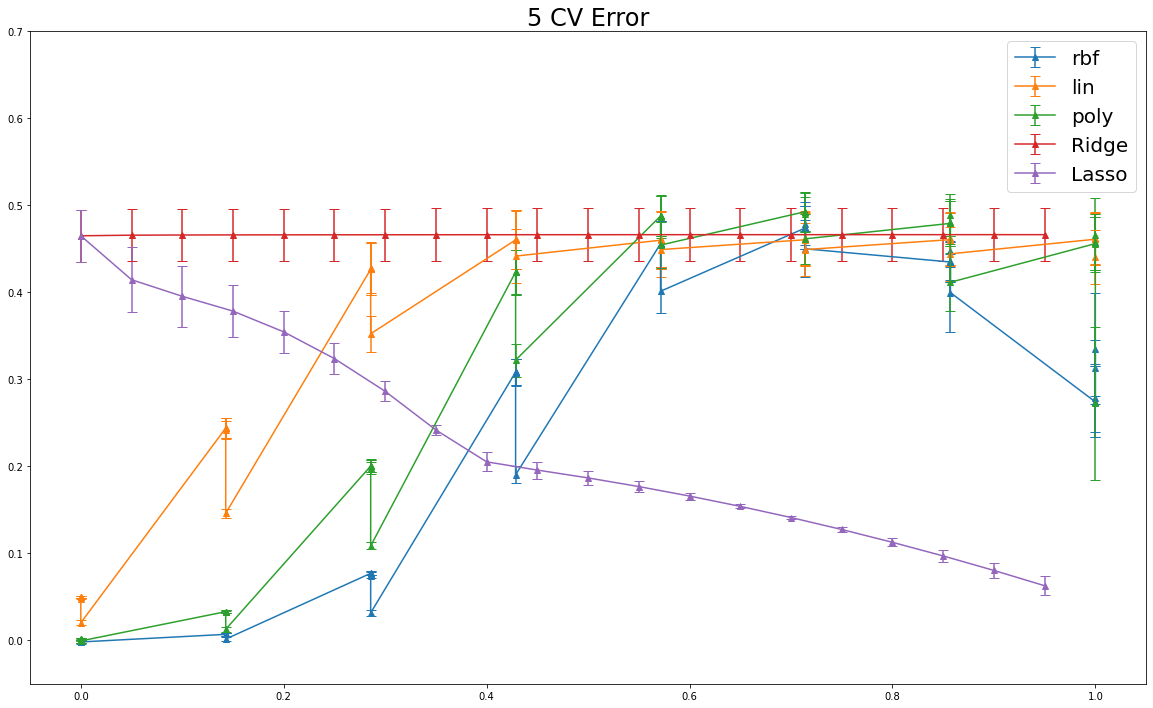

In [100]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

## GBM OOB J=6

In [101]:
gbm = GradientBoostingRegressor(learning_rate=0.02, 
                                n_estimators=1000, 
                                subsample=0.6, 
                                max_depth=6)
gbm.fit(X_train_pca, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  169  oob_improvement_:  -0.33957111824444447


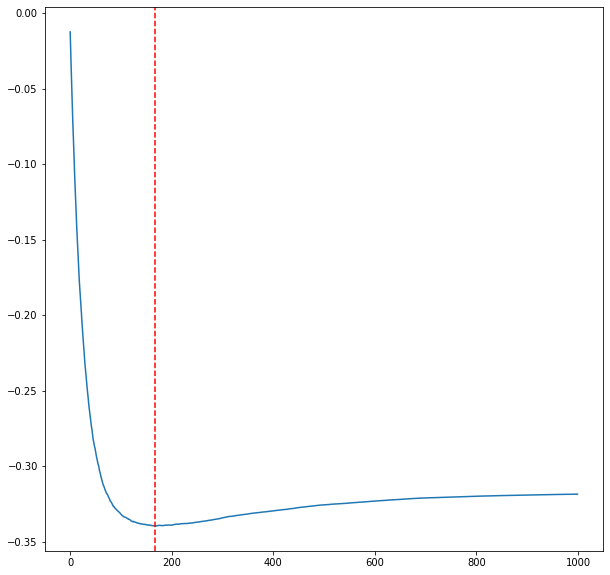

In [102]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [103]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X_train_pca, y_train)


print(gbm.oob_improvement_.sum())
print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', gbm.score(X_train_pca, y_train))
print('Test sin outliers ',gbm.score(X_test_pca, y_test))

results_in_color_pcatodas.append([gbm.score(X_train_pca, y_train), gbm.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('GBM J=6 reg.')

0.32912166065781245
RMSE train test
Train 0.37699325316303967
Test sin outliers  0.5991662686967868
R2 train test
Train 0.8187337606291571
Test sin outliers  0.5170013306656411


## GBM OOB J=4

In [104]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X_train_pca, y_train)


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  177  oob_improvement_:  -0.33708453434962254


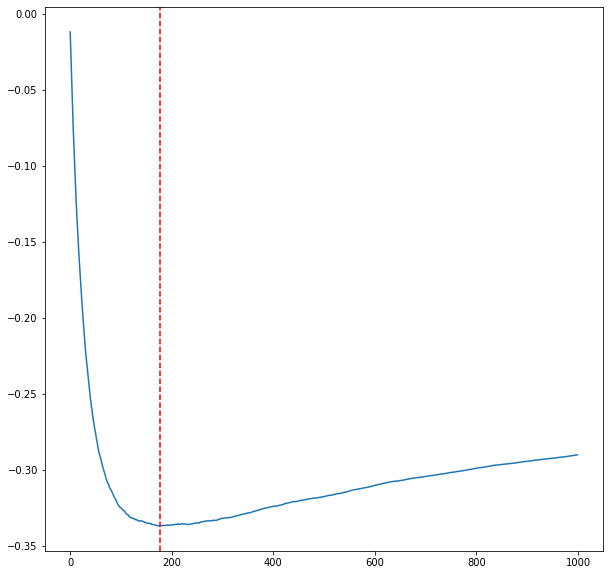

In [105]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [106]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X_train_pca, y_train)


print(gbm.oob_improvement_.sum())
print('RMSE train test')
print('Train', np.sqrt(np.mean((gbm.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((gbm.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', gbm.score(X_train_pca, y_train))
print('Test sin outliers ',gbm.score(X_test_pca, y_test))


results_in_color_pcatodas.append([gbm.score(X_train_pca, y_train), gbm.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('GBM J=4 reg.')

0.32872746450758583
RMSE train test
Train 0.5068034440741833
Test sin outliers  0.6010622646514805
R2 train test
Train 0.6724113215834895
Test sin outliers  0.5139397015729349


### RF reg.

In [107]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X_train_pca, y_train) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X_train_pca, y_train)

print('RMSE train test')
print('Train', np.sqrt(np.mean((rf.predict(X_train_pca)-y_train)**2)))
print('Test sin outliers ',np.sqrt(np.mean((rf.predict(X_test_pca)-y_test)**2)))
print('R2 train test')
print('Train', rf.score(X_train_pca, y_train))
print('Test sin outliers ',rf.score(X_test_pca, y_test))




results_in_color_pcatodas.append([rf.score(X_train_pca, y_train), rf.score(X_test_pca, y_test)])
results_in_color_pcatodas_y.append('RF Reg.')

[0.47284712 0.47147818 0.47237277]
RMSE train test
Train 0.23636687433530984
Test sin outliers  0.606295261858507
R2 train test
Train 0.9287437450284859
Test sin outliers  0.5054393356955416


# Ejercicio 2

*a. Reemplace este procesamiento por el uso de PCA y seleccione 21 componentes principales para realizar la regresión. Compare los resultados de realizar la regresión con todas las componentes de PCA y con la cantidad anteriormente pedida. Analice brevemente comparando con los valores que aparecen en la tabla del final del script. (1.5 pts)*


### Results in color

Text(0.5, 1.0, 'PCA todas las variables')

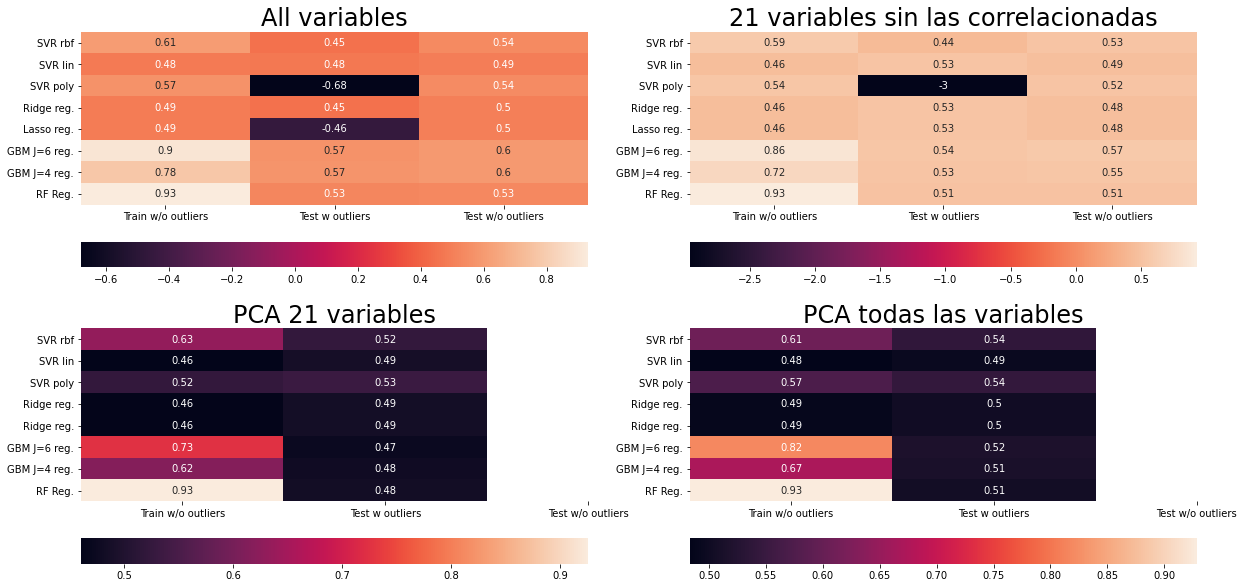

In [118]:
results_in_color_2 = np.array(results_in_color_2)
results_in_color_x_2 = np.array(results_in_color_x_2)
results_in_color_y_2 = np.array(results_in_color_y_2)

results_in_color_pca21 = np.array(results_in_color_pca21)
results_in_color_pca21_x = np.array(results_in_color_pca21_x)
results_in_color_pca21_y = np.array(results_in_color_pca21_y)

results_in_color_pcatodas = np.array(results_in_color_pcatodas)
results_in_color_pcatodas_x = np.array(results_in_color_pcatodas_x)
results_in_color_pcatodas_y = np.array(results_in_color_pcatodas_y)



fig, ax = plt.subplots(2, 2, figsize= (20, 10))

ax[0,0] = sns.heatmap(results_in_color, 
                    annot=True, ax=ax[0,0], 
                    yticklabels=results_in_color_y, 
                    xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"}
                   )
ax[0,0].set_title('All variables', fontsize=24)



ax[0,1] = sns.heatmap(results_in_color_2, 
                      annot=True, 
                      ax=ax[0,1], 
                      yticklabels=results_in_color_y, 
                      xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"})
ax[0,1].set_title('21 variables sin las correlacionadas', fontsize=24)


ax[1,0] = sns.heatmap(results_in_color_pca21, 
                      annot=True, ax=ax[1,0] , 
                      yticklabels=results_in_color_pcatodas_y, 
                      xticklabels=results_in_color_pcatodas_x,
                    cbar_kws={"orientation": "horizontal"})
ax[1,0].set_title('PCA 21 variables', fontsize=24)



ax[1,1] = sns.heatmap(results_in_color_pcatodas, 
                      annot=True, ax=ax[1,1], 
                      yticklabels=results_in_color_pcatodas_y, 
                      xticklabels=results_in_color_pcatodas_x,
                    cbar_kws={"orientation": "horizontal"})
ax[1,1].set_title('PCA todas las variables', fontsize=24)




Usando PCA no mejoramos los indicadores. Si bien en train tenemos para el RF muy buenos valores, vemos que es muy amplia la diferencia con test, por lo que hay sobreajuste de los datos. Los modelos de arboles en general performan mejor, pero solo para train. 

*b. El modelo de regresión de Random Forest sobre ajusta los datos. ¿Cómo puede corregirlo sin utilizar Cross Validation ni cambiar el parámetro ‘n_estimators’? (1pt)*

Podríamos usar los parámetros max_depth y min_samples_split. El max_depth limita la profundidad del árbol, lobotomizandolo y creando un árbol mas pequeño y menos sobreajustado a los datos de entrenamiento. El min_samples_leaf es la cantidad minima de observaciones que tiene que haber en un nodo para que sea un nodo hoja (sin seguir dividiéndose). Si mantenemos este número alto forzamos a tener hojas con mas observaciones que conforman un árbol que generaliza mejor.